In [1]:
from __future__ import print_function

### VGP notebook1. FFN

#### Signs of VGP

1. Parameters in the higher layers change significantly, while parameters of the lower layers hardly change.
2. Loss gradients shrink to zero.
3. Model learns slowly; loss stops decreasing after a few epochs.
4. Hidden layer activation values drop to zero as epochs increase.

In [2]:
# Load data and imports
import numpy as np
from sklearn.model_selection import GridSearchCV
from numpy import array, asarray, zeros
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras import Input, Model
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, LambdaCallback

# Hyperas for hyperparameter selection
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from keras import backend as k
tf.compat.v1.disable_eager_execution()

### 1. Import Pima dataset

In [3]:
# Load data
import os 
os.chdir('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/NLP tutorial')
dataset= np.loadtxt('Pima_data.txt', delimiter=',')
np.random.seed(7)

X= dataset[:,0:8]; y= dataset[:,8]
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.shape)
dataset[:5]

(768, 8)


array([[6.000e+00, 1.480e+02, 7.200e+01, 3.500e+01, 0.000e+00, 3.360e+01,
        6.270e-01, 5.000e+01, 1.000e+00],
       [1.000e+00, 8.500e+01, 6.600e+01, 2.900e+01, 0.000e+00, 2.660e+01,
        3.510e-01, 3.100e+01, 0.000e+00],
       [8.000e+00, 1.830e+02, 6.400e+01, 0.000e+00, 0.000e+00, 2.330e+01,
        6.720e-01, 3.200e+01, 1.000e+00],
       [1.000e+00, 8.900e+01, 6.600e+01, 2.300e+01, 9.400e+01, 2.810e+01,
        1.670e-01, 2.100e+01, 0.000e+00],
       [0.000e+00, 1.370e+02, 4.000e+01, 3.500e+01, 1.680e+02, 4.310e+01,
        2.288e+00, 3.300e+01, 1.000e+00]])

### 2. Three-hidden layers
#### 2.1 Define and fit model; extract weights for each epoch in the process

In [4]:
model_sig_3= Sequential()  
# Use sigmoid hidden layer
model_sig_3.add(Dense(10, input_dim= 8, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_s3 = {}  # key: epoch.  value: 
weight_callback_s3 = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_s3.update({epoch:model_sig_3.get_weights()}))
# Update the dictionary with get_weights() on_epoch_end
# Each get_weights() returns weight-bias for all the layers (hidden and output)


# Call back the hidden outputs on each epoch
s3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    # A list of output tensor variables for all layers:
    outputs= [layer.output for layer in model.layers]
    # Each out is an output tensor for one layer
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    s3_activations.append(layer_activations)
activations_callback_s3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_sig_3))

# Train model
tr_results = model_sig_3.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_s3, activations_callback_s3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 - 0s - loss: 0.6824 - accuracy: 0.6531 - val_loss: 0.6763 - val_accuracy: 0.6429
Epoch 2/100
614/614 - 0s - loss: 0.6696 - accuracy: 0.6531 - val_loss: 0.6662 - val_accuracy: 0.6429
Epoch 3/100
614/614 - 0s - loss: 0.6596 - accuracy: 0.6531 - val_loss: 0.6587 - val_accuracy: 0.6429


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 4/100
614/614 - 0s - loss: 0.6525 - accuracy: 0.6531 - val_loss: 0.6543 - val_accuracy: 0.6429
Epoch 5/100
614/614 - 0s - loss: 0.6484 - accuracy: 0.6531 - val_loss: 0.6520 - val_accuracy: 0.6429
Epoch 6/100
614/614 - 0s - loss: 0.6465 - accuracy: 0.6531 - val_loss: 0.6512 - val_accuracy: 0.6429
Epoch 7/100
614/614 - 0s - loss: 0.6453 - accuracy: 0.6531 - val_loss: 0.6509 - val_accuracy: 0.6429
Epoch 8/100
614/614 - 0s - loss: 0.6449 - accuracy: 0.6531 - val_loss: 0.6506 - val_accuracy: 0.6429
Epoch 9/100
614/614 - 0s - loss: 0.6443 - accuracy: 0.6531 - val_loss: 0.6504 - val_accuracy: 0.6429
Epoch 10/100
614/614 - 0s - loss: 0.6439 - accuracy: 0.6531 - val_loss: 0.6502 - val_accuracy: 0.6429
Epoch 11/100
614/614 - 0s - loss: 0.6434 - accuracy: 0.6531 - val_loss: 0.6500 - val_accuracy: 0.6429
Epoch 12/100
614/614 - 0s - loss: 0.6435 - accuracy: 0.6531 - val_loss: 0.6501 - val_accuracy: 0.6429
Epoch 13/100
614/614 - 0s - loss: 0.6426 - accuracy: 0.6531 - val_loss: 0.6493 - val_acc

Epoch 85/100
614/614 - 0s - loss: 0.5743 - accuracy: 0.6531 - val_loss: 0.5842 - val_accuracy: 0.6429
Epoch 86/100
614/614 - 0s - loss: 0.5727 - accuracy: 0.6531 - val_loss: 0.5821 - val_accuracy: 0.6429
Epoch 87/100
614/614 - 0s - loss: 0.5708 - accuracy: 0.6531 - val_loss: 0.5808 - val_accuracy: 0.6429
Epoch 88/100
614/614 - 0s - loss: 0.5690 - accuracy: 0.6531 - val_loss: 0.5793 - val_accuracy: 0.6429
Epoch 89/100
614/614 - 0s - loss: 0.5676 - accuracy: 0.6531 - val_loss: 0.5780 - val_accuracy: 0.6429
Epoch 90/100
614/614 - 0s - loss: 0.5652 - accuracy: 0.6531 - val_loss: 0.5757 - val_accuracy: 0.6429
Epoch 91/100
614/614 - 0s - loss: 0.5635 - accuracy: 0.6531 - val_loss: 0.5739 - val_accuracy: 0.6429
Epoch 92/100
614/614 - 0s - loss: 0.5617 - accuracy: 0.6531 - val_loss: 0.5722 - val_accuracy: 0.6429
Epoch 93/100
614/614 - 0s - loss: 0.5602 - accuracy: 0.6531 - val_loss: 0.5705 - val_accuracy: 0.6429
Epoch 94/100
614/614 - 0s - loss: 0.5582 - accuracy: 0.6531 - val_loss: 0.5691 - v

#### 2.2 Examine the weights on the 1st hidden layer over the epochs:

In [11]:
print(len(weights_dict_s3))  # 100 for 100-epochs
[len(weights_dict_s3[ep]) for ep in range(100)]  # 8 objects in each epoch-output
# i.e. 4 weights and 4 biases; 
weights_id= [0,2,4,6]

w_ep1_L1= weights_dict_s3[0][0]  

# On the 1st layer the weights have shape (10,10)
real_s3_weights_L1= []
for epoch,weights in weights_dict_s3.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    real_s3_weights_L1.append(weights[0])
    print(weights[0])



100
Weights for 1st Layer of epoch # 1
[[ 1.31100370e-02  2.97768433e-02 -5.46607338e-02  2.36698613e-02
  -1.82498223e-03 -1.49857849e-02 -4.54391390e-02  3.34848301e-03
   3.36602107e-02 -2.77326237e-02]
 [-2.81441212e-02 -4.39323038e-02  3.22354697e-02 -2.38836021e-03
   5.45061827e-02  2.81920023e-02  1.06830122e-02  3.40414830e-02
  -5.99637628e-03 -9.43606906e-03]
 [ 3.88906971e-02  3.63800526e-02  3.54557782e-02  1.56401843e-02
  -3.82639021e-02 -4.30979319e-02  3.92767452e-02  4.71258722e-02
  -3.98638211e-02 -1.14814248e-02]
 [-2.03993693e-02  3.97475585e-02  4.65042852e-02  2.43175328e-02
   3.93991992e-02  1.19354976e-02 -4.02549729e-02 -4.27970663e-03
   1.43865338e-02 -6.29707356e-05]
 [-2.31719594e-02  1.40326563e-02 -4.43950966e-02  9.76260751e-03
   3.19251493e-02 -2.46567857e-02 -2.46547554e-02  4.35005268e-03
  -3.74333262e-02  1.97797228e-04]
 [ 3.35689075e-02  1.10224858e-02  1.15614198e-03  3.78507525e-02
   4.93003689e-02  3.14210691e-02  3.33294533e-02  3.3059246

In [9]:
real_s3_weights_L2= []
for epoch,weights in weights_dict_s3.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    real_s3_weights_L2.append(weights[2])
    print(weights[2])


Weights for 1st Layer of epoch # 1
[[ 0.00618774 -0.04217112  0.05206526 -0.00938583  0.0516974   0.00074798
   0.03698586 -0.05062621 -0.04193618  0.04558206]
 [-0.01307337  0.00062079  0.03278769 -0.05155988  0.05715888 -0.00846332
  -0.02527881  0.02511132  0.04013613  0.06131453]
 [ 0.0032212   0.02876403 -0.01812277 -0.00873275  0.06180509 -0.05551774
   0.03146608 -0.02462404 -0.04149599 -0.00221828]
 [-0.03250016 -0.0015537  -0.02844609  0.01377972  0.0341703  -0.0314504
   0.04139819  0.01252609 -0.02298515 -0.02054077]
 [-0.00940879  0.01556464 -0.0202747  -0.01882113  0.04098357  0.02274793
  -0.02873631 -0.00255851 -0.02414522 -0.01117271]
 [ 0.00255443 -0.01627037 -0.03226359 -0.03983617 -0.00043528  0.00764999
   0.00607359  0.02940457 -0.0466309  -0.00459136]
 [ 0.02072049  0.05386065 -0.00235913 -0.02293351  0.00036914 -0.0281037
   0.02590141 -0.02192987 -0.05562799 -0.0025378 ]
 [-0.02526711  0.0030271  -0.01305542  0.02811862  0.02257307  0.00290979
   0.04281072 -0.0

In [10]:
# Examine the weights on the 3rd hidden layer over the epochs
# # On the 1st layer the weights have shape (10,10)
real_s3_weights_L3=[]
for epoch, weight in weights_dict_s3.items():
    print('Weights for 3rd Layer of epoch #',epoch+1)
    real_s3_weights_L3.append(weights[4])
    print(weights[4])

Weights for 3rd Layer of epoch # 1
[[0.2946857  0.3738366  0.3799016  0.2922416  0.29011354 0.37143084
  0.32131174 0.37980688 0.3532618  0.30498415]
 [0.37826875 0.3539496  0.38177568 0.33894888 0.3142546  0.36443764
  0.35480216 0.37106207 0.3600766  0.39404616]
 [0.38847002 0.33205232 0.36736125 0.38113895 0.35280782 0.34173357
  0.32721084 0.31809565 0.3859461  0.37283206]
 [0.42381388 0.33855292 0.41337442 0.39535972 0.35790545 0.38818935
  0.32932684 0.32805988 0.40361586 0.36861274]
 [0.36774847 0.38143718 0.385672   0.33917806 0.3803775  0.40310386
  0.4078942  0.34569693 0.3545478  0.3692814 ]
 [0.3858048  0.40285233 0.39728057 0.45728642 0.3731363  0.35069793
  0.37917486 0.34696826 0.41368753 0.39850762]
 [0.33697596 0.39117792 0.35985708 0.3322097  0.34029484 0.3111801
  0.38027516 0.361551   0.3614151  0.36791164]
 [0.36882153 0.4120845  0.3838456  0.37608203 0.32814562 0.37045208
  0.37757093 0.31355765 0.37190506 0.376623  ]
 [0.34631512 0.3164835  0.41339985 0.31939292 

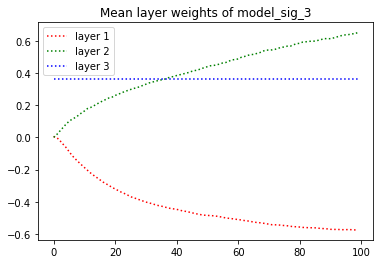

In [12]:
# Visualise the mean weights over epochs:
s3_aveW_L1= [np.mean(W) for W in real_s3_weights_L1]
s3_aveW_L2= [np.mean(W) for W in real_s3_weights_L2]
s3_aveW_L3= [np.mean(W) for W in real_s3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, s3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, s3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, s3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_sig_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_meanW_s3.png')


## To Figure Out:
Why is the weights not changing on the 2nd, 3rd hidden layer? 
<br>
VGP should make the LOWER layer weights frozen, not the upper layer.

#### 2.3 Extract gradients wrt weight on the 1st hidden layer (indexed 0)

In [13]:
ffn_grad_s3= k.gradients(model_sig_3.output, model_sig_3.trainable_weights)
ffn_grad_s3


[<tf.Tensor 'gradients/dense/MatMul_grad/MatMul_1:0' shape=(8, 10) dtype=float32>,
 <tf.Tensor 'gradients/dense/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients/dense_1/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients/dense_2/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients/dense_2/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients/dense_3/MatMul_grad/MatMul_1:0' shape=(10, 1) dtype=float32>,
 <tf.Tensor 'gradients/dense_3/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [14]:
sess = k.get_session()
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_s3_L1 = sess.run(ffn_grad_s3[0], feed_dict={model_sig_3.input: X})
gradients_s3_L2 = sess.run(ffn_grad_s3[2], feed_dict={model_sig_3.input: X})
gradients_s3_L3 = sess.run(ffn_grad_s3[4], feed_dict={model_sig_3.input: X})
print('Output grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L1.flatten())).describe())
print('Output grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L2.flatten())).describe())
print('Output grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L3.flatten())).describe())
gradients_s3_L1

Output grad wrt 1st hidden layer weights 
                0
count  80.000000
mean    0.166443
std     0.155025
min     0.003162
25%     0.018297
50%     0.118594
75%     0.304308
max     0.553534
Output grad wrt 2nd hidden layer weights 
                 0
count  100.000000
mean     0.613421
std      0.024746
min      0.562817
25%      0.594514
50%      0.611001
75%      0.632128
max      0.675004
Output grad wrt 3rd hidden layer weights 
                 0
count  100.000000
mean     2.292085
std      0.428677
min      1.275876
25%      2.216262
50%      2.418471
75%      2.571373
max      2.755387


array([[-0.31142968, -0.29085726, -0.3039325 , -0.29704303, -0.24481323,
        -0.2668806 , -0.2585224 , -0.28438878, -0.30367726, -0.35594934],
       [ 0.02806814,  0.03612708,  0.00711229,  0.02417254,  0.01223427,
         0.01860563,  0.02117583,  0.00872629,  0.02660062,  0.00986295],
       [-0.154389  , -0.15512441, -0.14462642, -0.1439312 , -0.11049467,
        -0.11900692, -0.14442858, -0.13795471, -0.13132495, -0.148664  ],
       [ 0.01625027, -0.01011535,  0.02062063, -0.00368994,  0.00631587,
         0.01304266,  0.00821583,  0.02489703,  0.01569126,  0.04748566],
       [ 0.10294878,  0.08416571,  0.11818181,  0.08946808,  0.08250912,
         0.09840323,  0.08497321,  0.09774254,  0.10951799,  0.13104837],
       [-0.35496467, -0.37077284, -0.31490174, -0.3380512 , -0.27299762,
        -0.29010555, -0.33933845, -0.30543637, -0.31206316, -0.32753852],
       [-0.00316172, -0.01736924, -0.00467221,  0.02000489,  0.00622234,
        -0.00524679, -0.00812452,  0.00389211

#### 2.4 Per-epoch Activations in hidden layers

In [48]:
model_sig_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_33 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 11        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [49]:
# View activations of model_sig_3 by [epoch][layer][0][X][unit]
# 30 epochs:
print(len(s3_activations))
# 4 layers in the 1st epoch:
print(len(s3_activations[0])) 

# 3rd index: always [0]
# 768 values in 1st layer[0] for the entire input batch
print(len(s3_activations[0][0][0]))

# 1st epoch; 1st layer; 1st input
# There are 10 outputs (10 units on 1st hidden layer)
print(len(s3_activations[0][0][0][0]))
print('\n10 Activations on the 1st epoch; 1st layer; for 1st input: \n', 
     s3_activations[0][0][0][0])

print('\n10 Activations on the 30th epoch; 3rd layer; for 1st input: \n', 
     s3_activations[29][2][0][0])


30
4
768
10

10 Activations on the 1st epoch; 1st layer; for 1st input: 
 [0.5074     0.5061759  0.49060103 0.5111601  0.49465698 0.50028795
 0.4880428  0.48660427 0.49228853 0.50182706]

10 Activations on the 30th epoch; 3rd layer; for 1st input: 
 [0.63560784 0.73149747 0.69699395 0.715197   0.5887846  0.6999643
 0.7249816  0.5180611  0.6997191  0.6132231 ]


#### Visualise activations over the epochs for each of the 3 hidden layers

In [15]:
s3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [10,10,10]; input_size= X.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  # (3,784)
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= s3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        s3_act_layers[layer, ep]= layer_ave_out
    


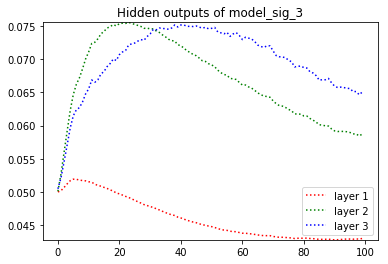

In [16]:
acts_L1= s3_act_layers[0]; acts_L2= s3_act_layers[1]; acts_L3= s3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(s3_act_layers), np.max(s3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_sig_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/AE_s3.png')


#### VGP checklist for 3-hidden layer sigmoid model
1. Change in weights over epochs:
<br>
Lower layer weights have been slowly updating; but the upper layers weights are completely frozen.
2. Loss gradients:
<br>
We see the loss gradients wrt weights are closer to zero on the lower layers.
3. Training loss and accuracy:
<br>
Training loss decreases slowly, while training accuracy stopped increasing at the 2nd epoch.
4. Hidden activations:
<br>
Higher layers exhibit trends of shrinking towards zero.

Apart from the mystery wrt change in weights over epochs, model_sig_3 depicts clear evidence of VGP.

### To experiment: tanh act.fct; 5 hidden layers.

In [17]:
model_tanh_3= Sequential()  
# Use tanh hidden layer
model_tanh_3.add(Dense(10, input_dim= 8, activation= 'tanh', kernel_initializer= 'uniform'))
model_tanh_3.add(Dense(10, input_dim= 10, activation= 'tanh', kernel_initializer= 'uniform'))
model_tanh_3.add(Dense(10, input_dim= 10, activation= 'tanh', kernel_initializer= 'uniform'))
model_tanh_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_tanh_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_t3 = {}
weight_callback_t3 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_t3.update({epoch:model_tanh_3.get_weights()}))

# Call back the hidden outputs on each epoch
t3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    t3_activations.append(layer_activations)
activations_callback_t3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_tanh_3))

# Train model
tr_results = model_tanh_3.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_t3, activations_callback_t3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 - 0s - loss: 0.6914 - accuracy: 0.6515 - val_loss: 0.6893 - val_accuracy: 0.6429
Epoch 2/100
614/614 - 0s - loss: 0.6854 - accuracy: 0.6531 - val_loss: 0.6798 - val_accuracy: 0.6429


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 3/100
614/614 - 0s - loss: 0.6684 - accuracy: 0.6596 - val_loss: 0.6523 - val_accuracy: 0.6494
Epoch 4/100
614/614 - 0s - loss: 0.6237 - accuracy: 0.7329 - val_loss: 0.5973 - val_accuracy: 0.7273
Epoch 5/100
614/614 - 0s - loss: 0.5646 - accuracy: 0.7394 - val_loss: 0.5448 - val_accuracy: 0.7468
Epoch 6/100
614/614 - 0s - loss: 0.5236 - accuracy: 0.7508 - val_loss: 0.5166 - val_accuracy: 0.7727
Epoch 7/100
614/614 - 0s - loss: 0.4999 - accuracy: 0.7720 - val_loss: 0.5039 - val_accuracy: 0.7597
Epoch 8/100
614/614 - 0s - loss: 0.4861 - accuracy: 0.7834 - val_loss: 0.5020 - val_accuracy: 0.7532
Epoch 9/100
614/614 - 0s - loss: 0.4792 - accuracy: 0.7883 - val_loss: 0.4995 - val_accuracy: 0.7468
Epoch 10/100
614/614 - 0s - loss: 0.4762 - accuracy: 0.7850 - val_loss: 0.4983 - val_accuracy: 0.7468
Epoch 11/100
614/614 - 0s - loss: 0.4745 - accuracy: 0.7850 - val_loss: 0.4965 - val_accuracy: 0.7403
Epoch 12/100
614/614 - 0s - loss: 0.4736 - accuracy: 0.7899 - val_loss: 0.4945 - val_accu

Epoch 84/100
614/614 - 0s - loss: 0.4670 - accuracy: 0.7834 - val_loss: 0.4862 - val_accuracy: 0.7532
Epoch 85/100
614/614 - 0s - loss: 0.4680 - accuracy: 0.7818 - val_loss: 0.4863 - val_accuracy: 0.7532
Epoch 86/100
614/614 - 0s - loss: 0.4679 - accuracy: 0.7801 - val_loss: 0.4903 - val_accuracy: 0.7532
Epoch 87/100
614/614 - 0s - loss: 0.4670 - accuracy: 0.7850 - val_loss: 0.4928 - val_accuracy: 0.7532
Epoch 88/100
614/614 - 0s - loss: 0.4675 - accuracy: 0.7834 - val_loss: 0.4871 - val_accuracy: 0.7468
Epoch 89/100
614/614 - 0s - loss: 0.4675 - accuracy: 0.7785 - val_loss: 0.4840 - val_accuracy: 0.7597
Epoch 90/100
614/614 - 0s - loss: 0.4674 - accuracy: 0.7834 - val_loss: 0.4845 - val_accuracy: 0.7532
Epoch 91/100
614/614 - 0s - loss: 0.4667 - accuracy: 0.7850 - val_loss: 0.4847 - val_accuracy: 0.7532
Epoch 92/100
614/614 - 0s - loss: 0.4671 - accuracy: 0.7801 - val_loss: 0.4869 - val_accuracy: 0.7468
Epoch 93/100
614/614 - 0s - loss: 0.4666 - accuracy: 0.7850 - val_loss: 0.4873 - v

In [20]:
model_sig_5= Sequential()  
# Use sigmoid hidden layer
model_sig_5.add(Dense(10, input_dim= 8, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.add(Dense(10, input_dim= 10, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_5.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_s5 = {}
weight_callback_s5 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_s5.update({epoch:model_sig_5.get_weights()}))

# Call back the hidden outputs on each epoch
s5_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    s5_activations.append(layer_activations)
activations_callback_s5= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_sig_5))

# Train model
tr_results = model_sig_5.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_s5, activations_callback_s5])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 614 samples, validate on 154 samples
Epoch 1/100


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



614/614 - 0s - loss: 0.7004 - accuracy: 0.3730 - val_loss: 0.6907 - val_accuracy: 0.6429
Epoch 2/100
614/614 - 0s - loss: 0.6838 - accuracy: 0.6531 - val_loss: 0.6783 - val_accuracy: 0.6429
Epoch 3/100
614/614 - 0s - loss: 0.6722 - accuracy: 0.6531 - val_loss: 0.6683 - val_accuracy: 0.6429
Epoch 4/100
614/614 - 0s - loss: 0.6626 - accuracy: 0.6531 - val_loss: 0.6619 - val_accuracy: 0.6429
Epoch 5/100
614/614 - 0s - loss: 0.6558 - accuracy: 0.6531 - val_loss: 0.6567 - val_accuracy: 0.6429
Epoch 6/100
614/614 - 0s - loss: 0.6507 - accuracy: 0.6531 - val_loss: 0.6534 - val_accuracy: 0.6429
Epoch 7/100
614/614 - 0s - loss: 0.6477 - accuracy: 0.6531 - val_loss: 0.6520 - val_accuracy: 0.6429
Epoch 8/100
614/614 - 0s - loss: 0.6460 - accuracy: 0.6531 - val_loss: 0.6518 - val_accuracy: 0.6429
Epoch 9/100
614/614 - 0s - loss: 0.6457 - accuracy: 0.6531 - val_loss: 0.6517 - val_accuracy: 0.6429
Epoch 10/100
614/614 - 0s - loss: 0.6457 - accuracy: 0.6531 - val_loss: 0.6519 - val_accuracy: 0.6429
E

Epoch 82/100
614/614 - 0s - loss: 0.6408 - accuracy: 0.6531 - val_loss: 0.6474 - val_accuracy: 0.6429
Epoch 83/100
614/614 - 0s - loss: 0.6405 - accuracy: 0.6531 - val_loss: 0.6474 - val_accuracy: 0.6429
Epoch 84/100
614/614 - 0s - loss: 0.6402 - accuracy: 0.6531 - val_loss: 0.6471 - val_accuracy: 0.6429
Epoch 85/100
614/614 - 0s - loss: 0.6399 - accuracy: 0.6531 - val_loss: 0.6467 - val_accuracy: 0.6429
Epoch 86/100
614/614 - 0s - loss: 0.6396 - accuracy: 0.6531 - val_loss: 0.6465 - val_accuracy: 0.6429
Epoch 87/100
614/614 - 0s - loss: 0.6390 - accuracy: 0.6531 - val_loss: 0.6465 - val_accuracy: 0.6429
Epoch 88/100
614/614 - 0s - loss: 0.6389 - accuracy: 0.6531 - val_loss: 0.6464 - val_accuracy: 0.6429
Epoch 89/100
614/614 - 0s - loss: 0.6388 - accuracy: 0.6531 - val_loss: 0.6462 - val_accuracy: 0.6429
Epoch 90/100
614/614 - 0s - loss: 0.6384 - accuracy: 0.6531 - val_loss: 0.6455 - val_accuracy: 0.6429
Epoch 91/100
614/614 - 0s - loss: 0.6379 - accuracy: 0.6531 - val_loss: 0.6454 - v

Weights for 1st Layer of epoch # 1
[[ 0.0407722   0.02373832 -0.02410019 -0.02941943  0.04315176 -0.04688767
   0.02725139  0.02743932  0.0366503  -0.02633887]
 [-0.03698807  0.03398479 -0.04783799  0.04855764  0.02921319  0.00831893
  -0.02103383 -0.00321733 -0.00854419  0.04739045]
 [ 0.0304689   0.04348313 -0.01950668  0.03653776 -0.01042937  0.01079305
   0.0404367   0.02369501 -0.00197415 -0.03452412]
 [ 0.0345379  -0.01284674 -0.03859242 -0.04963172  0.01663836 -0.04874885
  -0.03234468 -0.01067743  0.02372912 -0.01955272]
 [-0.01366532 -0.0080582  -0.04000733  0.00143566 -0.02828543  0.03138918
   0.03942718 -0.01644533  0.01067817  0.02586993]
 [ 0.01479121  0.00359411 -0.03863573 -0.01210231 -0.01773281 -0.04714968
  -0.0246662  -0.02964091  0.0186484  -0.04009582]
 [ 0.04681868  0.02040121  0.0187431  -0.00966394  0.03240941  0.00432493
   0.01643905  0.03740352  0.00264729 -0.0050064 ]
 [-0.01254651  0.00393863 -0.03243774 -0.00797578 -0.02179066  0.02658407
   0.01129169  0

  -0.40076473 -0.36241695 -0.42641428 -0.39903948]]
Weights for 1st Layer of epoch # 31
[[-0.3897897  -0.405321   -0.4338269  -0.44525906 -0.38961372 -0.4581558
  -0.4034128  -0.40647194 -0.39449197 -0.44219738]
 [-0.7478236  -0.67627716 -0.76114845 -0.66529447 -0.68536454 -0.7058372
  -0.73463434 -0.71818924 -0.7230808  -0.66667414]
 [-0.01856522 -0.01398005 -0.04021168 -0.01707666 -0.05003899 -0.0276606
  -0.00965904 -0.02220193 -0.04441928 -0.06540467]
 [-0.04216761 -0.07600026 -0.06733835 -0.09548729 -0.04931848 -0.09374645
  -0.0868165  -0.06761895 -0.04894767 -0.07691745]
 [-0.3208039  -0.3162798  -0.33202085 -0.30800635 -0.33545595 -0.2889158
  -0.2820857  -0.32728487 -0.30490965 -0.29546013]
 [-0.6072524  -0.614605   -0.6599136  -0.63218373 -0.64035267 -0.6663769
  -0.64599305 -0.6517338  -0.6057472  -0.6582816 ]
 [-0.39722115 -0.41306877 -0.41764498 -0.43733898 -0.41011605 -0.42768863
  -0.42041534 -0.40404743 -0.43448594 -0.43546715]
 [-0.42150116 -0.40731198 -0.42766926 -0.4

  -0.4388115  -0.40033072 -0.46434832 -0.43648726]]
Weights for 1st Layer of epoch # 48
[[-0.46174008 -0.47589296 -0.48961756 -0.5019082  -0.45805424 -0.51352483
  -0.47278643 -0.4786891  -0.4612555  -0.49935803]
 [-1.1178051  -1.0499177  -1.1171691  -1.0253638  -1.0427853  -1.064738
  -1.0938613  -1.0869938  -1.0819607  -1.030168  ]
 [ 0.06777778  0.06982619  0.05435893  0.06664852  0.04343108  0.06088992
   0.07273932  0.06403456  0.04725203  0.03442401]
 [ 0.05929555  0.03712285  0.04338697  0.02061808  0.05735895  0.01897234
   0.02204752  0.04301804  0.05392496  0.03592087]
 [-0.36248    -0.35620862 -0.36595148 -0.3454026  -0.37111074 -0.33519164
  -0.3298569  -0.36947927 -0.34710518 -0.34068543]
 [-0.89332026 -0.90270954 -0.9326395  -0.9092187  -0.91462564 -0.94064647
  -0.9218254  -0.93456537 -0.8833406  -0.93565124]
 [-0.55783415 -0.56681734 -0.56659913 -0.578375   -0.56032056 -0.572375
  -0.5698767  -0.5605299  -0.582399   -0.5802872 ]
 [-0.45401257 -0.445227   -0.4469703  -0.

  0.21319953 0.19194476 0.22746913 0.23428118]]
Weights for 3rd Layer of epoch # 46
[[0.24391042 0.20114428 0.19686109 0.16928004 0.19315772 0.15845387
  0.22017251 0.14863966 0.15591447 0.164086  ]
 [0.20026681 0.17899293 0.18653762 0.18167217 0.22705531 0.23658577
  0.20160195 0.23757374 0.17643517 0.21982978]
 [0.19630155 0.16353732 0.24265586 0.16948317 0.17879006 0.17968835
  0.15756315 0.21901539 0.16630535 0.23508728]
 [0.19058394 0.16889735 0.21517828 0.17564754 0.2155485  0.22304589
  0.19243625 0.23535441 0.23891784 0.16179685]
 [0.16081034 0.18193118 0.18958353 0.19410773 0.1763689  0.18772797
  0.22794868 0.23429996 0.18849804 0.21136205]
 [0.15831684 0.18558615 0.17263219 0.21976365 0.21853428 0.2334154
  0.2229143  0.16146892 0.17313328 0.23476735]
 [0.23921376 0.18072443 0.19196805 0.24995506 0.22972839 0.15586291
  0.18089779 0.15252522 0.25369295 0.18904284]
 [0.18392746 0.23948164 0.17007966 0.22022533 0.18800138 0.17691603
  0.20776023 0.20595045 0.23767552 0.1482014

  0.30639228 0.28472066 0.31832206 0.32683903]]
Weights for 3rd Layer of epoch # 78
[[0.3506455  0.307226   0.30278525 0.27427268 0.30040115 0.2652775
  0.32762992 0.25586206 0.26108125 0.27095255]
 [0.29327905 0.27166075 0.27892095 0.27337632 0.32077172 0.3296586
  0.29558206 0.33118695 0.26815087 0.31321344]
 [0.29834476 0.26502693 0.34394813 0.26992533 0.2814036  0.28181154
  0.26040617 0.32158116 0.26686963 0.3373385 ]
 [0.27342248 0.2516734  0.2975396  0.2575573  0.29928225 0.30591527
  0.27648464 0.31891242 0.32068884 0.24522904]
 [0.24718589 0.2681663  0.27543512 0.27944446 0.2635915  0.27414143
  0.31547338 0.3213673  0.27373692 0.2982714 ]
 [0.26610425 0.2926295  0.27957273 0.32570082 0.3267569  0.34130362
  0.3313301  0.2696922  0.27929577 0.34261125]
 [0.3399975  0.28093833 0.2920029  0.3491284  0.3310619  0.25673077
  0.28245375 0.2538135  0.3529991  0.29001966]
 [0.27747154 0.33268225 0.26299182 0.31245813 0.28225362 0.2705195
  0.30227748 0.3000996  0.32991895 0.24211892]

  0.07988796 0.0767859  0.1281414  0.1380147 ]]
Weights for 4th Layer of epoch # 6
[[0.11695046 0.12258973 0.12755708 0.07377309 0.06907152 0.12518995
  0.06854621 0.14004707 0.08382077 0.1249382 ]
 [0.08255132 0.12179184 0.12324016 0.11053443 0.08796097 0.06747752
  0.13607572 0.09496488 0.1320895  0.10416604]
 [0.09895872 0.05931022 0.15208142 0.11909269 0.12540422 0.12139707
  0.14099808 0.10566603 0.09899103 0.14418283]
 [0.17123546 0.13082325 0.06466816 0.06973477 0.08740918 0.15551648
  0.10924664 0.09515052 0.1082662  0.15968622]
 [0.13519119 0.14681381 0.0937423  0.06266952 0.05724414 0.12438014
  0.15685357 0.05495046 0.10874988 0.10545651]
 [0.07919807 0.12104272 0.14712068 0.11505827 0.05486831 0.13840352
  0.11839131 0.10026336 0.0674917  0.14944823]
 [0.10362881 0.0487287  0.09458864 0.1010106  0.10437138 0.1154599
  0.13237466 0.07641319 0.12359025 0.11129071]
 [0.13109386 0.07670558 0.10897158 0.07374985 0.05143713 0.08814485
  0.13906574 0.12706065 0.09356303 0.09659094

  0.14269927 0.13693528 0.19128136 0.20066945]]
Weights for 4th Layer of epoch # 27
[[0.1571908  0.16451286 0.16611642 0.11904407 0.11538052 0.16261192
  0.10805263 0.18070805 0.12422511 0.16354226]
 [0.12242804 0.16336003 0.16148882 0.15549044 0.13397071 0.1045888
  0.17522924 0.13533172 0.17216147 0.14238189]
 [0.13928205 0.10132395 0.19073772 0.16446106 0.17180584 0.15892293
  0.18058932 0.14643785 0.13948503 0.1828651 ]
 [0.21070856 0.17201585 0.10251569 0.11430454 0.13301528 0.19223551
  0.14799564 0.13514534 0.14793448 0.19749881]
 [0.17518681 0.18848245 0.1321085  0.10773111 0.1033728  0.16160053
  0.19612727 0.09541266 0.14894073 0.14379153]
 [0.11951449 0.16303961 0.18575092 0.16039707 0.10124184 0.17589782
  0.15797299 0.14099258 0.10796827 0.18813242]
 [0.14371963 0.0904726  0.1330577  0.14616492 0.15061313 0.15277281
  0.17174648 0.11695713 0.16388305 0.14971474]
 [0.17110671 0.11839318 0.14734612 0.11882196 0.09757078 0.12537535
  0.17835464 0.16753224 0.13376558 0.1349478

   0.07151451  0.01698646 -0.01375366  0.09871645]]
Weights for 5th Layer of epoch # 41
[[ 0.10363881  0.14386478  0.0467192   0.03814721  0.04013169  0.03912677
   0.1204664   0.01218055  0.03206208  0.14065236]
 [ 0.10095139  0.10242719  0.05280172  0.05871224 -0.00109911  0.05435198
   0.11460806 -0.03047324 -0.00167856  0.17426604]
 [ 0.15204778  0.0859489   0.03606005  0.09736707  0.08961187  0.13724189
   0.11651292  0.03988641 -0.01655113  0.18393065]
 [ 0.12523356  0.11830195  0.04749174  0.05174307  0.01113744  0.07509078
   0.11302969  0.02473501 -0.03228976  0.13206768]
 [ 0.08128736  0.1699289   0.10298591  0.1032994   0.04535037  0.0780732
   0.08477192 -0.00256949 -0.00110706  0.17971884]
 [ 0.17447022  0.0989814   0.03592236  0.09582946  0.09321792  0.0560363
   0.09780794  0.02220124 -0.02886037  0.17177053]
 [ 0.10538352  0.09951883  0.10320623  0.07533265  0.04192977  0.09560841
   0.15178208 -0.01254697  0.00292044  0.12062813]
 [ 0.1661353   0.09291273  0.08785061  

  0.09224652 0.06150431 0.02887495 0.10828385]]
Weights for 5th Layer of epoch # 71
[[0.12095681 0.16594204 0.08377305 0.07536332 0.08379836 0.07113501
  0.1412938  0.05751368 0.07530494 0.1500387 ]
 [0.11944243 0.12573662 0.09120372 0.0972776  0.04394814 0.08767364
  0.13666418 0.01615855 0.04278674 0.18480153]
 [0.17010409 0.10877813 0.07388097 0.13535176 0.13404335 0.1700151
  0.1380949  0.08593477 0.02736797 0.1940656 ]
 [0.14233625 0.14027387 0.0848104  0.08922338 0.05524747 0.10723308
  0.13371626 0.07064386 0.0115427  0.14102927]
 [0.0986992  0.19221134 0.14064865 0.14112352 0.08982055 0.11054721
  0.10576404 0.04370818 0.04308674 0.18895605]
 [0.19228931 0.1215719  0.07348282 0.13355318 0.13737826 0.08855671
  0.1191537  0.06797322 0.01478892 0.18168744]
 [0.12310176 0.12198989 0.14062741 0.11291703 0.08594736 0.12799463
  0.17300755 0.03310488 0.04646218 0.13043469]
 [0.18398422 0.11559716 0.12571378 0.07782734 0.06112115 0.14473908
  0.16565216 0.0155576  0.01299538 0.1265340

Weights for 5th Layer of epoch # 93
[[0.15175639 0.20141357 0.13587667 0.12822756 0.14673696 0.11739051
  0.17590973 0.12776195 0.13891116 0.1747873 ]
 [0.15272821 0.16373841 0.14587611 0.152738   0.10948229 0.13650383
  0.17383485 0.08881271 0.10845305 0.21213281]
 [0.20093457 0.14428875 0.12606157 0.18829088 0.19708155 0.2163319
  0.1727456  0.15631108 0.09111326 0.218824  ]
 [0.17144346 0.174155   0.13582735 0.14098091 0.11744867 0.15219021
  0.16667889 0.14082767 0.07543314 0.16377576]
 [0.12716383 0.22545065 0.19110283 0.19230826 0.15151396 0.15490265
  0.13806733 0.11353641 0.10674398 0.21097742]
 [0.22329615 0.15725906 0.12579933 0.18663114 0.20052224 0.13502823
  0.15398851 0.13838342 0.0785243  0.20666105]
 [0.15433364 0.15788375 0.19310518 0.16615961 0.14922754 0.17464615
  0.20805387 0.10361296 0.11026435 0.15565182]
 [0.21461445 0.15096478 0.1779678  0.13083827 0.12438224 0.19104387
  0.20014024 0.08638898 0.07726076 0.15099274]
 [0.17673217 0.14513235 0.18860354 0.13669272

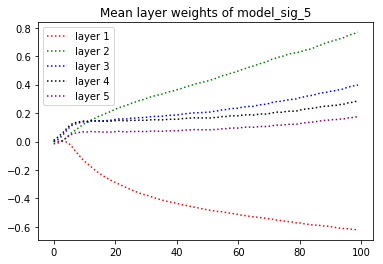

In [21]:
real_s5_weights_L1= []
for epoch,weights in weights_dict_s5.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    real_s5_weights_L1.append(weights[0])
    print(weights[0])
    
real_s5_weights_L2= []
for epoch,weights in weights_dict_s5.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    real_s5_weights_L2.append(weights[2])
    print(weights[2])
    
real_s5_weights_L3= []
for epoch,weights in weights_dict_s5.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    real_s5_weights_L3.append(weights[4])
    print(weights[4])
    
real_s5_weights_L4= []
for epoch,weights in weights_dict_s5.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 4th Layer of epoch #',epoch+1)
    real_s5_weights_L4.append(weights[6])
    print(weights[6])
    
real_s5_weights_L5= []
for epoch,weights in weights_dict_s5.items():
    # Each of the 100 'weights' contains 8 objects (weights and biases) 
    print('Weights for 5th Layer of epoch #',epoch+1)
    real_s5_weights_L5.append(weights[8])
    print(weights[8])

# Visualise the mean weights over epochs:
s5_aveW_L1= [np.mean(W) for W in real_s5_weights_L1]
s5_aveW_L2= [np.mean(W) for W in real_s5_weights_L2]
s5_aveW_L3= [np.mean(W) for W in real_s5_weights_L3]
s5_aveW_L4= [np.mean(W) for W in real_s5_weights_L4]
s5_aveW_L5= [np.mean(W) for W in real_s5_weights_L5]

epochs= [ep for ep in range(100)]
plt.plot(epochs, s5_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, s5_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, s5_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.plot(epochs, s5_aveW_L4, linestyle = 'dotted', color= 'black', label= 'layer 4')
plt.plot(epochs, s5_aveW_L5, linestyle = 'dotted', color= 'purple', label= 'layer 5')
plt.legend()
plt.title('Mean layer weights of model_sig_5')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_meanW_s5.png')


In [22]:
ffn_grad_s5= k.gradients(model_sig_5.output, model_sig_5.trainable_weights)
ffn_grad_s5

[<tf.Tensor 'gradients_1/dense_14/MatMul_grad/MatMul_1:0' shape=(8, 10) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_14/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_15/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_15/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_16/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_16/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_17/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_17/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_18/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_18/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_19/MatMul_grad/MatMul_1:0' shape=(10, 1) dtype=float32>,
 <tf.Tensor 'gradi

In [23]:
sess = k.get_session()
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_s5_L1 = sess.run(ffn_grad_s5[0], feed_dict={model_sig_5.input: X})
gradients_s5_L2 = sess.run(ffn_grad_s5[2], feed_dict={model_sig_5.input: X})
gradients_s5_L3 = sess.run(ffn_grad_s5[4], feed_dict={model_sig_5.input: X})
gradients_s5_L4 = sess.run(ffn_grad_s5[6], feed_dict={model_sig_5.input: X})
gradients_s5_L5 = sess.run(ffn_grad_s5[8], feed_dict={model_sig_5.input: X})
print('Output grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_s5_L1.flatten())).describe())
print('Output grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_s5_L2.flatten())).describe())
print('Output grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_s5_L3.flatten())).describe())
print('Output grad wrt 4th hidden layer weights \n',abs(pd.DataFrame(gradients_s5_L4.flatten())).describe())
print('Output grad wrt 5th hidden layer weights \n',abs(pd.DataFrame(gradients_s5_L5.flatten())).describe())



Output grad wrt 1st hidden layer weights 
                0
count  80.000000
mean    0.021343
std     0.018246
min     0.000408
25%     0.004762
50%     0.015087
75%     0.038142
max     0.064680
Output grad wrt 2nd hidden layer weights 
                 0
count  100.000000
mean     0.044352
std      0.001628
min      0.041028
25%      0.043311
50%      0.044560
75%      0.045543
max      0.047532
Output grad wrt 3rd hidden layer weights 
                 0
count  100.000000
mean     0.165126
std      0.004016
min      0.158217
25%      0.161584
50%      0.164745
75%      0.167764
max      0.173660
Output grad wrt 4th hidden layer weights 
                 0
count  100.000000
mean     0.490401
std      0.022187
min      0.459911
25%      0.470104
50%      0.494202
75%      0.497803
max      0.538336
Output grad wrt 5th hidden layer weights 
                 0
count  100.000000
mean     1.934200
std      0.774090
min      0.596945
25%      1.508960
50%      1.922386
75%      2.411358
ma

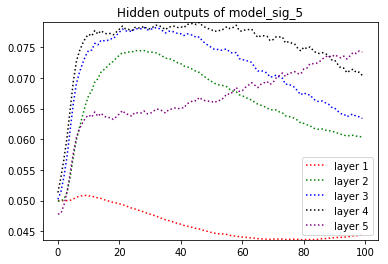

In [24]:
s5_act_layers= np.zeros((5, 100))  # each row is mean activation for that hidden layer
layer_sizes= [10,10,10,10,10]; input_size= X.shape[0]
for ep in range(100):
    for layer in range(5):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= s5_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        s5_act_layers[layer, ep]= layer_ave_out

acts_L1= s5_act_layers[0]; acts_L2= s5_act_layers[1]; acts_L3= s5_act_layers[2]
acts_L4= s5_act_layers[3]; acts_L5= s5_act_layers[4]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.plot(epochs, acts_L4, linestyle = 'dotted', color= 'black', label= 'layer 4')
plt.plot(epochs, acts_L5, linestyle = 'dotted', color= 'purple', label= 'layer 5')
plt.ylim((np.min(s5_act_layers), np.max(s5_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_sig_5')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/AE_s5.png')
  

### 2.5 VGP solutions
#### 2.5.1 ReLU-class activation functions

In [25]:
# ReLU
model_relu_3= Sequential()  
# Use ReLU hidden layer
model_relu_3.add(Dense(10, input_dim= 8, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(10, input_dim= 10, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(10, input_dim= 10, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_relu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_r3 = {}
weight_callback_r3 = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_r3.update({epoch:model_relu_3.get_weights()}))

# Call back the hidden activations
r3_activations= []
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    r3_activations.append(layer_activations)
activations_callback_r3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_relu_3))

# Train model
tr_results = model_relu_3.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_r3, activations_callback_r3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))



Train on 614 samples, validate on 154 samples
Epoch 1/100


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



614/614 - 0s - loss: 0.6917 - accuracy: 0.6368 - val_loss: 0.6900 - val_accuracy: 0.6429
Epoch 2/100
614/614 - 0s - loss: 0.6874 - accuracy: 0.6531 - val_loss: 0.6853 - val_accuracy: 0.6429
Epoch 3/100
614/614 - 0s - loss: 0.6803 - accuracy: 0.6531 - val_loss: 0.6759 - val_accuracy: 0.6429
Epoch 4/100
614/614 - 0s - loss: 0.6647 - accuracy: 0.6531 - val_loss: 0.6538 - val_accuracy: 0.6429
Epoch 5/100
614/614 - 0s - loss: 0.6301 - accuracy: 0.6531 - val_loss: 0.6101 - val_accuracy: 0.6429
Epoch 6/100
614/614 - 0s - loss: 0.5771 - accuracy: 0.6531 - val_loss: 0.5603 - val_accuracy: 0.6429
Epoch 7/100
614/614 - 0s - loss: 0.5360 - accuracy: 0.6531 - val_loss: 0.5369 - val_accuracy: 0.6429
Epoch 8/100
614/614 - 0s - loss: 0.5172 - accuracy: 0.6531 - val_loss: 0.5235 - val_accuracy: 0.6429
Epoch 9/100
614/614 - 0s - loss: 0.5112 - accuracy: 0.6596 - val_loss: 0.5172 - val_accuracy: 0.6558
Epoch 10/100
614/614 - 0s - loss: 0.5058 - accuracy: 0.7671 - val_loss: 0.5121 - val_accuracy: 0.7597
E

Epoch 82/100
614/614 - 0s - loss: 0.4378 - accuracy: 0.7980 - val_loss: 0.4847 - val_accuracy: 0.7468
Epoch 83/100
614/614 - 0s - loss: 0.4377 - accuracy: 0.7997 - val_loss: 0.4807 - val_accuracy: 0.7468
Epoch 84/100
614/614 - 0s - loss: 0.4376 - accuracy: 0.7997 - val_loss: 0.4828 - val_accuracy: 0.7468
Epoch 85/100
614/614 - 0s - loss: 0.4369 - accuracy: 0.7915 - val_loss: 0.4830 - val_accuracy: 0.7532
Epoch 86/100
614/614 - 0s - loss: 0.4373 - accuracy: 0.7964 - val_loss: 0.4862 - val_accuracy: 0.7468
Epoch 87/100
614/614 - 0s - loss: 0.4365 - accuracy: 0.7980 - val_loss: 0.4857 - val_accuracy: 0.7532
Epoch 88/100
614/614 - 0s - loss: 0.4362 - accuracy: 0.7964 - val_loss: 0.4844 - val_accuracy: 0.7532
Epoch 89/100
614/614 - 0s - loss: 0.4364 - accuracy: 0.7980 - val_loss: 0.4862 - val_accuracy: 0.7532
Epoch 90/100
614/614 - 0s - loss: 0.4359 - accuracy: 0.7948 - val_loss: 0.4825 - val_accuracy: 0.7532
Epoch 91/100
614/614 - 0s - loss: 0.4353 - accuracy: 0.7980 - val_loss: 0.4862 - v

ReLU model improves training accuracy.

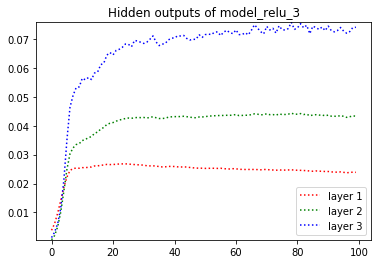

In [26]:
# Create mean-activation object for plotting
r3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [10,10,10]; input_size= X.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  # (3,768)
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= r3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        r3_act_layers[layer, ep]= layer_ave_out
    
acts_L1= r3_act_layers[0]; acts_L2= r3_act_layers[1]; acts_L3= r3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(r3_act_layers), np.max(r3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_relu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/AE_r3.png')


In [27]:
# ELU
model_elu_3= Sequential()  
# Use ReLU hidden layer
model_elu_3.add(Dense(10, input_dim= 8, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_e3 = {}
weight_callback_e3 = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

# Call back the hidden outputs on each epoch
e3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    e3_activations.append(layer_activations)
activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))


# Train model
tr_results = model_elu_3.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))



Train on 614 samples, validate on 154 samples
Epoch 1/100


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



614/614 - 0s - loss: 0.6913 - accuracy: 0.6547 - val_loss: 0.6887 - val_accuracy: 0.6429
Epoch 2/100
614/614 - 0s - loss: 0.6845 - accuracy: 0.6531 - val_loss: 0.6786 - val_accuracy: 0.6429
Epoch 3/100
614/614 - 0s - loss: 0.6665 - accuracy: 0.6564 - val_loss: 0.6513 - val_accuracy: 0.6299
Epoch 4/100
614/614 - 0s - loss: 0.6241 - accuracy: 0.7085 - val_loss: 0.5991 - val_accuracy: 0.7078
Epoch 5/100
614/614 - 0s - loss: 0.5626 - accuracy: 0.7345 - val_loss: 0.5405 - val_accuracy: 0.7338
Epoch 6/100
614/614 - 0s - loss: 0.5166 - accuracy: 0.7345 - val_loss: 0.5090 - val_accuracy: 0.7727
Epoch 7/100
614/614 - 0s - loss: 0.4942 - accuracy: 0.7524 - val_loss: 0.4985 - val_accuracy: 0.7727
Epoch 8/100
614/614 - 0s - loss: 0.4830 - accuracy: 0.7704 - val_loss: 0.4911 - val_accuracy: 0.7662
Epoch 9/100
614/614 - 0s - loss: 0.4754 - accuracy: 0.7850 - val_loss: 0.4934 - val_accuracy: 0.7597
Epoch 10/100
614/614 - 0s - loss: 0.4740 - accuracy: 0.7866 - val_loss: 0.4906 - val_accuracy: 0.7597
E

Epoch 82/100
614/614 - 0s - loss: 0.4595 - accuracy: 0.7850 - val_loss: 0.4785 - val_accuracy: 0.7597
Epoch 83/100
614/614 - 0s - loss: 0.4596 - accuracy: 0.7883 - val_loss: 0.4803 - val_accuracy: 0.7597
Epoch 84/100
614/614 - 0s - loss: 0.4597 - accuracy: 0.7834 - val_loss: 0.4780 - val_accuracy: 0.7597
Epoch 85/100
614/614 - 0s - loss: 0.4585 - accuracy: 0.7866 - val_loss: 0.4802 - val_accuracy: 0.7597
Epoch 86/100
614/614 - 0s - loss: 0.4588 - accuracy: 0.7850 - val_loss: 0.4788 - val_accuracy: 0.7597
Epoch 87/100
614/614 - 0s - loss: 0.4581 - accuracy: 0.7834 - val_loss: 0.4823 - val_accuracy: 0.7532
Epoch 88/100
614/614 - 0s - loss: 0.4582 - accuracy: 0.7915 - val_loss: 0.4797 - val_accuracy: 0.7662
Epoch 89/100
614/614 - 0s - loss: 0.4580 - accuracy: 0.7834 - val_loss: 0.4808 - val_accuracy: 0.7597
Epoch 90/100
614/614 - 0s - loss: 0.4586 - accuracy: 0.7866 - val_loss: 0.4769 - val_accuracy: 0.7597
Epoch 91/100
614/614 - 0s - loss: 0.4571 - accuracy: 0.7866 - val_loss: 0.4782 - v

#### Similarly as done with model_sig_3, check for signs of VGP
1. Weights in each layer over epochs.

In [28]:
print(len(weights_dict_e3))  # 30 for 30-epochs
[len(weights_dict_e3[ep]) for ep in range(100)]  # 8 objects in each epoch-output
# i.e. 4 weights and 4 biases; 
weights_id= [0,2,4,6]

e3_weights_L1= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    e3_weights_L1.append(weights[0])
    print(weights[0])

100
Weights for 1st Layer of epoch # 1
[[-0.0589179  -0.02854866 -0.04030734 -0.02159225  0.03484285  0.05360456
  -0.00689427 -0.02968678 -0.0009722  -0.03492882]
 [ 0.00308563  0.03290121 -0.06632771  0.04287965  0.00246318  0.03561335
   0.01380167 -0.02602527 -0.03502527 -0.0477113 ]
 [-0.04672218  0.01460298 -0.0532819   0.04091688 -0.03969943  0.05276237
   0.01775374 -0.00808427 -0.00774646 -0.05736022]
 [-0.03569666  0.05455932 -0.03945454 -0.00784434 -0.0094864  -0.01292679
  -0.00526138  0.02843095 -0.02721443 -0.02894764]
 [ 0.00904213  0.00336433 -0.05131617  0.01846381  0.03690839 -0.0013519
  -0.00960737  0.01062187 -0.0125128  -0.00539731]
 [-0.01599582 -0.02550227 -0.01819218  0.00036373  0.04689499 -0.02805718
  -0.04375862 -0.06298895  0.02528063 -0.03056816]
 [-0.02995132  0.03095996  0.00200071 -0.02770135 -0.02627721  0.03913564
   0.00560296 -0.03989492 -0.01664949  0.03139063]
 [-0.01123742  0.0547167   0.01225891 -0.02176011  0.03639884 -0.01455077
   0.00184345

In [29]:
# On the 2nd layer the weights have shape (10,10)
e3_weights_L2= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    e3_weights_L2.append(weights[2])
    print(weights[2])

Weights for 2nd Layer of epoch # 1
[[ 0.03687627 -0.00544465 -0.02301005 -0.03567523  0.04073334  0.03214401
   0.00746696 -0.00380584 -0.00893929  0.04273386]
 [ 0.04066862 -0.00371759 -0.00196575  0.0518331  -0.02967011  0.02290035
  -0.00636155 -0.01159862 -0.02812389 -0.0014706 ]
 [-0.02859661 -0.00456703 -0.05295276 -0.03792327  0.05327078  0.02067956
   0.00143716 -0.03196172 -0.02000613  0.02778071]
 [-0.00573447 -0.02473635 -0.03574486  0.01052219  0.01147519 -0.01538699
   0.00012759 -0.0221369   0.04278158 -0.03797394]
 [ 0.0552934   0.03247396  0.05312197  0.0226408  -0.02830761 -0.04757154
  -0.03070966 -0.02486665 -0.02992467 -0.03218307]
 [ 0.02801364 -0.05604671  0.00222193 -0.01817975 -0.05534352 -0.03679745
   0.01531636 -0.01637266  0.01618607 -0.04929732]
 [ 0.01206185  0.01789262  0.03112009  0.00147306  0.02759744  0.02847777
  -0.02749681  0.00730846 -0.00981567  0.02473256]
 [-0.02092321  0.04761766 -0.02100059 -0.03228574  0.03059416 -0.03038749
  -0.03984191 -0

In [30]:
# On the 3rd layer the weights have shape (10,10)
e3_weights_L3= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    e3_weights_L3.append(weights[4])
    print(weights[4])

Weights for 3rd Layer of epoch # 1
[[-0.01527862 -0.02835559  0.02841367  0.03194409  0.00463784 -0.03986089
  -0.06606222 -0.02174604 -0.01962473  0.01706749]
 [ 0.024637   -0.02334561  0.04802342 -0.00731945 -0.00242289  0.04580208
   0.02655695  0.04476792  0.0267497  -0.03648573]
 [-0.04286133  0.01373741 -0.02889781  0.06241573 -0.00232826 -0.05231682
  -0.0376815   0.00338155 -0.00595462 -0.01447305]
 [-0.03811305  0.02592905 -0.06404033  0.01887814 -0.01106719 -0.05743112
  -0.05298491 -0.05618641 -0.02036367  0.01365323]
 [ 0.0663627  -0.00010343  0.04227478 -0.00148797 -0.01843848  0.05789235
  -0.02230739  0.04663831 -0.03079499 -0.06242238]
 [ 0.00664264  0.0288542   0.01184058 -0.04054841 -0.05078862  0.01327264
   0.00328897 -0.03787958 -0.0007759   0.0176164 ]
 [-0.02125475 -0.00571311 -0.03151577  0.0361017  -0.00885324 -0.06523918
  -0.06260412  0.02206956  0.03491836  0.06416696]
 [ 0.01906831 -0.02441614 -0.04946299 -0.02951263  0.0486251   0.00226108
  -0.04723307 -0

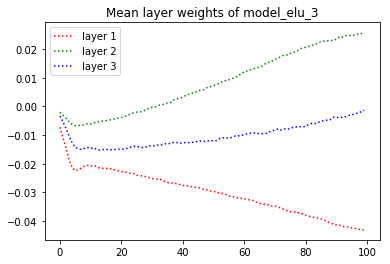

In [31]:
# Visualise the mean weights over epochs:
e3_aveW_L1= [np.mean(W) for W in e3_weights_L1]
e3_aveW_L2= [np.mean(W) for W in e3_weights_L2]
e3_aveW_L3= [np.mean(W) for W in e3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, e3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, e3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, e3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_meanW_e3.png')


#### Note that the upper layer weights are now updating over the epochs!

2. Loss gradients

In [32]:
ffn_grad_e3= k.gradients(model_elu_3.output, model_elu_3.trainable_weights)
ffn_grad_e3

[<tf.Tensor 'gradients_2/dense_24/MatMul_grad/MatMul_1:0' shape=(8, 10) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_24/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_25/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_25/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_26/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_26/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_27/MatMul_grad/MatMul_1:0' shape=(10, 1) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_27/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [33]:
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_e3_L1 = sess.run(ffn_grad_e3[0], feed_dict={model_elu_3.input: X})
gradients_e3_L2 = sess.run(ffn_grad_e3[2], feed_dict={model_elu_3.input: X})
gradients_e3_L3 = sess.run(ffn_grad_e3[4], feed_dict={model_elu_3.input: X})
print('Loss grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L1.flatten())).describe())
print('Loss grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L2.flatten())).describe())
print('Loss grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L3.flatten())).describe())
gradients_e3_L1

Loss grad wrt 1st hidden layer weights 
                0
count  80.000000
mean    6.958436
std     5.519175
min     0.077299
25%     3.065245
50%     5.646100
75%     9.649178
max    23.347229
Loss grad wrt 2nd hidden layer weights 
                 0
count  100.000000
mean     1.178239
std      0.874678
min      0.012157
25%      0.442734
50%      0.938248
75%      1.809536
max      3.709620
Loss grad wrt 3rd hidden layer weights 
                 0
count  100.000000
mean     2.516677
std      1.447000
min      0.212512
25%      1.133898
50%      2.454657
75%      3.991991
max      4.988414


array([[  0.81905407,   3.9987812 , -16.647215  ,   5.742951  ,
          7.817217  ,   7.4099417 , -10.312867  ,  10.595294  ,
         -6.5706267 ,   1.3938329 ],
       [ -2.805602  ,  12.045387  ,  -9.826712  ,  19.293865  ,
         17.151276  ,  14.894033  ,  -8.342592  , -10.624374  ,
         -5.9564257 ,  -4.083905  ],
       [ -0.73125815,   2.9194603 ,  -4.4280577 ,   3.677022  ,
          3.1700792 ,   3.824593  ,  -3.6666448 ,  -2.3190522 ,
         -2.8672924 ,  -0.7799567 ],
       [ -2.5290387 ,   4.299411  ,   5.5400624 ,   3.3791587 ,
          4.5336227 ,   4.138862  ,   1.7830021 , -18.221893  ,
         -0.07729925,  -3.969098  ],
       [ -4.9116573 ,   7.514837  ,   6.6030965 ,   9.59      ,
         10.758162  ,   8.512329  ,   0.7780324 , -23.347229  ,
         -1.3475882 ,  -7.2425995 ],
       [ -5.3396883 ,  10.69575   ,  -8.630914  ,  15.799923  ,
         15.21698   ,  13.137926  ,  -6.8321095 , -22.128227  ,
         -7.1302114 ,  -7.9779177 ],
       [ -

3. Hidden outputs

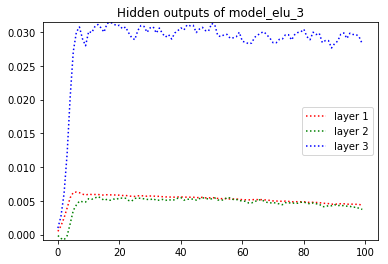

In [34]:
e3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [10,10,10]; input_size= X.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= e3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        e3_act_layers[layer, ep]= layer_ave_out
        
acts_L1= e3_act_layers[0]; acts_L2= e3_act_layers[1]; acts_L3= e3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(e3_act_layers), np.max(e3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_AE_e3.png')


#### VGP checklist for model_elu_3
1. Accuracy improved over the epochs. 
2. Weights on all layers are all updating over the epochs.
3. Loss gradients wrt lower hidden layer weights are also larger than those in model_sig_3.
4. Hidden outputs in layer 3 seems to be consistently small. This is likely due to activation computations, instead of vanishing gradients.

#### 2.5.2 Weight Initialisation on model_elu_3
Available initialisation schemes: ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'].
<br>
In this section we use hyperas to select the best performing weight initialisation.

In [30]:
np.random.seed(7)
def data():
    pima_data= np.loadtxt('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/NLP tutorial/Pima_data.txt',
                      delimiter=',')
    X= pima_data[:,0:8]
    y= pima_data[:,8]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    return X, y
    
    
    

In [34]:
def create_model_e3(X,y):
    model_elu_3= Sequential()  
    # Use ELU hidden layer
    model_elu_3.add(Dense(10, input_dim= 8, activation= 'elu', 
                          kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(1, activation= 'sigmoid', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    # Callback the weights on each epoch
    weights_dict_e3 = {}
    weight_callback_e3 = LambdaCallback \
    ( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

    # Callback the hidden activations on each epoch
    e3_activations= []
    def save_act(model):
        outputs= [layer.output for layer in model.layers]
        kfunc= [k.function([model.input], [out]) for out in outputs]
        layer_activations= [ f([X]) for f in kfunc]
        e3_activations.append(layer_activations)
    activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))

    # Train model
    tr_results = model_elu_3.fit(X, y, validation_split=0.2, epochs=30, batch_size=32, 
                                 verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])
    val_acc= np.amax(tr_results.history['val_accuracy'])
    return{'loss':-val_acc, 'status': STATUS_OK, 'model': model_elu_3, 
          'perepoch_weights': weights_dict_e3, 'hidden_acts':e3_activations}
    
    
if __name__ == '__main__':
    os.chdir('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/VGP illustration')
    X,y= data()
    best_run, best_model= optim.minimize(model= create_model_e3, data= data,
                                        algo= tpe.suggest, max_evals= 1, trials= Trials(),
                                        eval_space= True, notebook_name= 'VGP_1_FFN')
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from numpy import array, asarray, zeros
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.datasets import make_circles
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import Input, Model
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.recurrent import LSTM, GRU, SimpleRNN
except:
    pass

try:
    from keras.layers.core import Dense, Activation, Dropout, Flatten
except:
    pass

try:
    from keras.layers.embeddings import Embedding
except:
    pass

try:

/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.




614/614 - 0s - loss: 0.6125 - accuracy: 0.6547 - val_loss: 0.6103 - val_accuracy: 0.6429

Epoch 3/30                                           
614/614 - 0s - loss: 0.5990 - accuracy: 0.6531 - val_loss: 0.5975 - val_accuracy: 0.6429

Epoch 4/30                                           
614/614 - 0s - loss: 0.5821 - accuracy: 0.6612 - val_loss: 0.5805 - val_accuracy: 0.6558

Epoch 5/30                                           
614/614 - 0s - loss: 0.5624 - accuracy: 0.6906 - val_loss: 0.5625 - val_accuracy: 0.6558

Epoch 6/30                                           
614/614 - 0s - loss: 0.5400 - accuracy: 0.7052 - val_loss: 0.5391 - val_accuracy: 0.7273

Epoch 7/30                                           
614/614 - 0s - loss: 0.5176 - accuracy: 0.7573 - val_loss: 0.5192 - val_accuracy: 0.7662

Epoch 8/30                                           
614/614 - 0s - loss: 0.4987 - accuracy: 0.7752 - val_loss: 0.5017 - val_accuracy: 0.7597

Epoch 9/30                                    

Optimal weight initialisation for:
- 1st hidden layer: He normal
- 2nd hidden layer: random uniform
- 3rd hidden layer: Lecun uniform
- output layer: He normal

Next check for VGP under the optimal set of initialisation:

In [35]:
X,y= data()
model_elu_3= Sequential()  
# Use ELU hidden layer
model_elu_3.add(Dense(10, input_dim= 8, activation= 'elu', kernel_initializer= 'he_normal'))
model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', kernel_initializer='uniform'))
model_elu_3.add(Dense(10, input_dim= 10, activation= 'elu', kernel_initializer= 'lecun_uniform'))
model_elu_3.add(Dense(1, activation= 'sigmoid',  kernel_initializer= 'he_normal'))
model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Callback the weights on each epoch
weights_dict_e3 = {}
weight_callback_e3 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

# Callback the hidden activations on each epoch
e3_activations= []
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([X]) for f in kfunc]
    e3_activations.append(layer_activations)
activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))

# Train model
tr_results = model_elu_3.fit(X, y, validation_split=0.2, epochs=30, batch_size=32, 
                            verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])

e3_act_layers= np.zeros((3, 30))  # each row is mean activation for that hidden layer
layer_sizes= [10,10,10]; input_size= X.shape[0]
for ep in range(30):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  # (3,768)
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= e3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        e3_act_layers[layer, ep]= layer_ave_out

Train on 614 samples, validate on 154 samples
Epoch 1/30


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



614/614 - 0s - loss: 0.6523 - accuracy: 0.6515 - val_loss: 0.6297 - val_accuracy: 0.6429
Epoch 2/30
614/614 - 0s - loss: 0.6132 - accuracy: 0.6531 - val_loss: 0.6194 - val_accuracy: 0.6429
Epoch 3/30
614/614 - 0s - loss: 0.5982 - accuracy: 0.6564 - val_loss: 0.6025 - val_accuracy: 0.6429
Epoch 4/30
614/614 - 0s - loss: 0.5810 - accuracy: 0.6726 - val_loss: 0.5840 - val_accuracy: 0.6429
Epoch 5/30
614/614 - 0s - loss: 0.5609 - accuracy: 0.7085 - val_loss: 0.5631 - val_accuracy: 0.6753
Epoch 6/30
614/614 - 0s - loss: 0.5397 - accuracy: 0.7215 - val_loss: 0.5411 - val_accuracy: 0.7273
Epoch 7/30
614/614 - 0s - loss: 0.5188 - accuracy: 0.7476 - val_loss: 0.5193 - val_accuracy: 0.7597
Epoch 8/30
614/614 - 0s - loss: 0.5014 - accuracy: 0.7590 - val_loss: 0.5025 - val_accuracy: 0.7727
Epoch 9/30
614/614 - 0s - loss: 0.4918 - accuracy: 0.7557 - val_loss: 0.4904 - val_accuracy: 0.7727
Epoch 10/30
614/614 - 0s - loss: 0.4829 - accuracy: 0.7720 - val_loss: 0.4813 - val_accuracy: 0.7792
Epoch 11/3

Weights for 1st Layer of epoch # 1
[[ 0.20431934 -0.51323736 -0.9018832  -0.62883914  0.32753542 -0.3635359
   0.0469563  -0.37864184  0.6139189  -0.8298649 ]
 [-0.24437855 -0.20251565 -0.3400253   0.2827452  -0.3127765  -0.966329
  -0.7119787  -0.74613583  0.15348619 -0.2606955 ]
 [ 0.03181099  0.37230587 -0.27958724  0.62309545  0.30513808 -0.34516117
   0.38889146 -0.21557215 -0.44986776  0.05531103]
 [ 0.7065731   0.30750948 -0.5249873   0.7325228  -0.44400585  0.8164589
  -0.01128133 -0.7998213   0.49157664 -0.80507666]
 [-0.05200955 -0.18913972 -0.16782272 -0.9945888   0.38635823 -0.64532316
  -0.07897161 -0.83314407 -0.6056498  -0.38059443]
 [ 0.15114634  0.31941566  0.03605326 -0.20987481  0.17580117 -0.72012293
  -0.62787575  0.06440672  0.16824462  0.38247702]
 [ 0.43575966 -0.49679965 -0.1653704  -0.22057739 -0.27825445  0.8277732
  -0.57521874 -0.424385    0.5506589  -0.523786  ]
 [-0.40665624  0.289645   -0.03558121  0.11195432 -0.33944657 -0.16031413
   0.1494584   0.7796

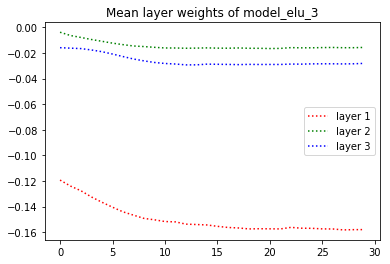

In [36]:
# A. Mean weights per epoch
e3_weights_L1= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 30 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    e3_weights_L1.append(weights[0])
    print(weights[0])
    
e3_weights_L2= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 30 'weights' contains 3 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    e3_weights_L2.append(weights[2])
    print(weights[2])
    
e3_weights_L3= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 30 'weights' contains 3 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    e3_weights_L3.append(weights[4])
    print(weights[4])
    
# Visualise the mean weights over epochs:
e3_aveW_L1= [np.mean(W) for W in e3_weights_L1]
e3_aveW_L2= [np.mean(W) for W in e3_weights_L2]
e3_aveW_L3= [np.mean(W) for W in e3_weights_L3]

epochs= [ep for ep in range(30)]
plt.plot(epochs, e3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, e3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, e3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_meanW_e3_init.png')


Loss grad wrt 1st hidden layer weights 
                 0
count   80.000000
mean    26.676052
std     34.702076
min      0.035154
25%      2.852866
50%      7.584755
75%     47.243097
max    144.746582
Loss grad wrt 2nd hidden layer weights 
                 0
count  100.000000
mean    46.583096
std     47.013996
min      0.339843
25%     13.672850
50%     27.782244
75%     68.076393
max    223.034378
Loss grad wrt 3rd hidden layer weights 
                 0
count  100.000000
mean     3.077336
std      3.456106
min      0.000989
25%      0.761075
50%      1.850666
75%      3.935721
max     14.800526


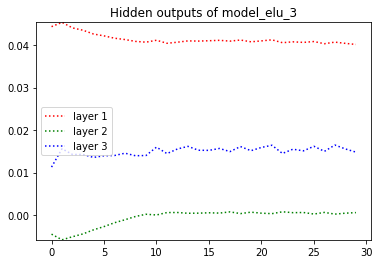

In [37]:
# 2. Loss gradients wrt weights
ffn_grad_e3= k.gradients(model_elu_3.output, model_elu_3.trainable_weights)
gradients_e3_L1 = sess.run(ffn_grad_e3[0], feed_dict={model_elu_3.input: X})
gradients_e3_L2 = sess.run(ffn_grad_e3[2], feed_dict={model_elu_3.input: X})
gradients_e3_L3 = sess.run(ffn_grad_e3[4], feed_dict={model_elu_3.input: X})
print('Loss grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L1.flatten())).describe())
print('Loss grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L2.flatten())).describe())
print('Loss grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L3.flatten())).describe())
gradients_e3_L1


# 3. Hidden activations per epoch
acts_L1= e3_act_layers[0]; acts_L2= e3_act_layers[1]; acts_L3= e3_act_layers[2]
epochs= [ep for ep in range(30)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(e3_act_layers), np.max(e3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/pima_AE_e3_init.png')


The updating of weights on lower layers is insignificant.

I tend to stop at models with 3 hidden layers to demonstrate VGP (provided they show signs of VGP according to theory).  
<br>
My aim is after all showing and solving VGP.

#### 3.2 Effect of weights multiplication

In [35]:
# Examine the product of weights in Sig3
idx= [0,2,4]
s3W= []
for i in range(len(idx)):
    index= idx[i]
    W= k.get_session().run(model_sig_3.trainable_weights[index])
    s3W.append(W)
#print(s3W)
print([mat.shape for mat in s3W])
s3W_prod= s3W[0] 
for i in range(2):
    s3W_prod = s3W_prod @ s3W[i+1]
print('Product of weights in 3 hidden layers of model_sig_3: \n',s3W_prod) 
print('')

[(8, 10), (10, 10), (10, 10)]
Product of weights in 3 hidden layers of model_sig_3: 
 [[-14.429654  -14.576781  -15.160307  -14.369781  -13.696468  -14.408102
  -14.013952  -13.688447  -14.721583  -14.678708 ]
 [-43.59551   -44.039948  -45.803     -43.41497   -41.38083   -43.530327
  -42.339405  -41.355743  -44.47747   -44.348267 ]
 [  7.464902    7.540929    7.8428626   7.4338527   7.085706    7.4537416
    7.2498155   7.081464    7.615889    7.5938044]
 [  5.111474    5.1636724   5.370413    5.090229    4.851718    5.103868
    4.96422     4.8488503   5.214828    5.199806 ]
 [ -8.239662   -8.323782   -8.656938   -8.205492   -7.821027   -8.22739
   -8.002354   -7.816414   -8.406377   -8.381914 ]
 [-33.49211   -33.83365   -35.18809   -33.35328   -31.790462  -33.44205
  -32.52717   -31.771515  -34.169655  -34.070362 ]
 [-17.804802  -17.986135  -18.706284  -17.730885  -16.900194  -17.778067
  -17.291721  -16.889925  -18.164873  -18.112104 ]
 [ -4.119232   -4.1613255  -4.3280706  -4.10198

In [38]:
# Examine the product of weights in Sig5
idx= [2,4,6,8]
s5W= []
for i in range(len(idx)):
    index= idx[i]
    W= k.get_session().run(model_sig_5.trainable_weights[index])
    s5W.append(W)
#print(s5W)
print([mat.shape for mat in s5W])
s5W_prod= s5W[2] 
for i in range(3):
    s5W_prod = s5W_prod @ s5W[i+1]
print('Product of weights in 4 hidden layers of model_sig_5: \n',s5W_prod) 
print('')

[(10, 10), (10, 10), (10, 10), (10, 10)]
Product of weights in 4 hidden layers of model_sig_5: 
 [[6.0998735 6.0109067 5.7599077 5.812515  5.5460014 5.9080415 6.073862
  4.8597484 4.0357246 6.2362385]
 [5.859407  5.773932  5.5328074 5.5833473 5.327356  5.6750917 5.834407
  4.6681366 3.8766248 5.9903984]
 [6.2846403 6.1929994 5.9343715 5.988571  5.7140036 6.0869603 6.2578163
  5.0069466 4.157977  6.425146 ]
 [5.787834  5.703435  5.465255  5.515193  5.262298  5.6058016 5.7631373
  4.611158  3.8292818 5.917248 ]
 [6.0001364 5.912632  5.6656923 5.7174807 5.4553227 5.811391  5.974515
  4.7802796 3.9697485 6.134299 ]
 [6.236273  6.1453037 5.888665  5.94248   5.6700187 6.0401096 6.2096395
  4.9684067 4.1259613 6.375689 ]
 [5.999289  5.911815  5.664923  5.716671  5.4545574 5.810579  5.97369
  4.7796082 3.9691908 6.133431 ]
 [5.901429  5.815398  5.5725203 5.6234093 5.365574  5.715768  5.8762608
  4.7016277 3.9044635 6.0334053]
 [6.009807  5.922158  5.6748714 5.7267103 5.464118  5.8208294 5.9841

In [38]:
e3W= []
for i in range(len(idx)):
    index= idx[i]
    W= k.get_session().run(model_elu_3.trainable_weights[index])
    e3W.append(W)
    
#print(e3W)
e3W_prod= e3W[0] 
for i in range(2):
    e3W_prod = e3W_prod @ e3W[i+1]
print('Product of weights in 3 hidden layers of model_elu_3: \n',e3W_prod)  

[(8, 10), (10, 10), (10, 10)]
Product of weights in 3 hidden layers of model_sig_3: 
 [[-0.85694826 -0.83529973 -0.9388205  -0.8511178  -0.79660714  0.13791603
  -0.8816922  -0.5902262  -0.7644839  -0.33993003]
 [-1.6838286  -1.6414506  -1.8445158  -1.6724037  -1.565204    0.27104303
  -1.7323916  -1.1593993  -1.5021702  -0.66796994]
 [-0.5130662  -0.5001613  -0.56196237 -0.5094182  -0.47682804  0.08251882
  -0.5277724  -0.3532741  -0.45756423 -0.2035007 ]
 [-0.11809205 -0.11542779 -0.13015515 -0.11784752 -0.1099375   0.01902811
  -0.12189709 -0.08136643 -0.10579608 -0.04716093]
 [-0.21570489 -0.21027255 -0.23654409 -0.21479213 -0.20046242  0.03464318
  -0.22195414 -0.14873306 -0.19294046 -0.08567287]
 [-1.5734012  -1.5333343  -1.7221689  -1.5612248  -1.4624046   0.25348723
  -1.6181188  -1.082602   -1.401693   -0.6236586 ]
 [-0.39027944 -0.3802374  -0.42651588 -0.3866529  -0.3627121   0.06301106
  -0.40100652 -0.26820555 -0.34698713 -0.15449005]
 [-0.7598084  -0.73994017 -0.8307927  -

Conclusion: when weights are not square, we do not see matrix multiplication leading to vanishing/exploding entry values. Because the argument based on largest eigenvalue is not applicable here. 

### 1. Illustrate VGP with simulated dataset
To illustrate the effect of weights multiplication, we use the same number of hidden units on each layer.

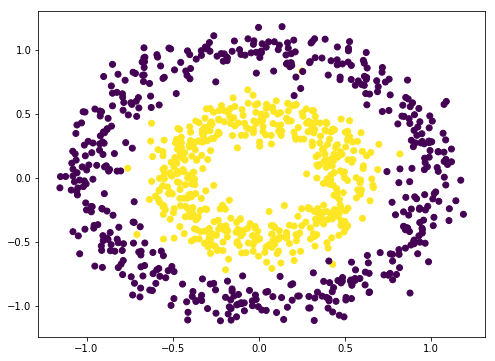

In [3]:
# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
 
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
xtr, xte, ytr, yte= train_test_split(X, y,random_state= 42,test_size= 0.3, shuffle= True)

### 4.1 VGP in sig_3 model
#### 4.1.1 training

In [5]:
model_sig_3= Sequential()  
# Use sigmoid hidden layer
model_sig_3.add(Dense(3, input_dim= 2, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(3, input_dim= 3, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(3, input_dim= 3, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_sig_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_s3 = {}
weight_callback_s3 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_s3.update({epoch:model_sig_3.get_weights()}))

# Call back the hidden outputs on each epoch
s3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([xtr]) for f in kfunc]
    s3_activations.append(layer_activations)
activations_callback_s3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_sig_3))

# Train model
tr_results = model_sig_3.fit(xtr, ytr, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_s3, activations_callback_s3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 560 samples, validate on 140 samples
Epoch 1/100
560/560 - 0s - loss: 0.6934 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4786
Epoch 2/100
560/560 - 0s - loss: 0.6933 - accuracy: 0.4911 - val_loss: 0.6933 - val_accuracy: 0.4786
Epoch 3/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.4839 - val_loss: 0.6931 - val_accuracy: 0.5214


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 4/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.4518 - val_loss: 0.6931 - val_accuracy: 0.5214
Epoch 5/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 6/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 7/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 8/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 9/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6927 - val_accuracy: 0.5214
Epoch 10/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6927 - val_accuracy: 0.5214
Epoch 11/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 12/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6927 - val_accuracy: 0.5214
Epoch 13/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6927 - val_acc

Epoch 85/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 86/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 87/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6924 - val_accuracy: 0.5214
Epoch 88/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 89/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 90/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 91/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 92/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 93/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5214
Epoch 94/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - v

#### 4.1.2 Checks for signs
A. Weights

In [6]:
s3_weights_L1= []
for epoch,weights in weights_dict_s3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    s3_weights_L1.append(weights[0])
    print(weights[0])

Weights for 1st Layer of epoch # 1
[[-0.02742898 -0.03088462  0.0478568 ]
 [ 0.04121884  0.04641294  0.00506787]]
Weights for 1st Layer of epoch # 2
[[-0.02746119 -0.03093372  0.04785132]
 [ 0.04127624  0.04650414  0.0050776 ]]
Weights for 1st Layer of epoch # 3
[[-0.02751005 -0.03101022  0.04784165]
 [ 0.04126026  0.04648852  0.00507538]]
Weights for 1st Layer of epoch # 4
[[-0.02755803 -0.03109605  0.0478305 ]
 [ 0.04129495  0.04655092  0.00508379]]
Weights for 1st Layer of epoch # 5
[[-0.02760319 -0.03118353  0.04781845]
 [ 0.04135024  0.04665281  0.00509797]]
Weights for 1st Layer of epoch # 6
[[-0.02762059 -0.03121544  0.0478123 ]
 [ 0.04137786  0.04674786  0.0051047 ]]
Weights for 1st Layer of epoch # 7
[[-0.02763498 -0.03131543  0.04780712]
 [ 0.04140798  0.04690429  0.0051166 ]]
Weights for 1st Layer of epoch # 8
[[-0.02764589 -0.03135511  0.04780156]
 [ 0.04139609  0.04698393  0.00510904]]
Weights for 1st Layer of epoch # 9
[[-0.02765055 -0.03154226  0.04779808]
 [ 0.04135238 

In [7]:
s3_weights_L2= []
for epoch,weights in weights_dict_s3.items():
    # Each of the 100 'weights' contains 5 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    s3_weights_L2.append(weights[2])
    print(weights[2])

Weights for 1st Layer of epoch # 1
[[-0.04765696  0.0039731   0.00212912]
 [-0.01068811  0.01914909 -0.03237807]
 [-0.02213238 -0.02531312  0.01947523]]
Weights for 1st Layer of epoch # 2
[[-0.04780308  0.00419523  0.00249654]
 [-0.01083821  0.01936682 -0.03201604]
 [-0.02223363 -0.02504121  0.01990385]]
Weights for 1st Layer of epoch # 3
[[-0.04955903  0.00245237  0.00045384]
 [-0.01259463  0.01762311 -0.03405977]
 [-0.02396872 -0.0267585   0.01789138]]
Weights for 1st Layer of epoch # 4
[[-0.05014508  0.00213582  0.00011568]
 [-0.01318301  0.01730364 -0.03440137]
 [-0.02452179 -0.02703324  0.0176026 ]]
Weights for 1st Layer of epoch # 5
[[-0.05146604  0.00063211 -0.00163118]
 [-0.01450671  0.01579633 -0.03615242]
 [-0.02581101 -0.02849351  0.01590637]]
Weights for 1st Layer of epoch # 6
[[-0.05335974 -0.00196471 -0.0045964 ]
 [-0.01640133  0.01319722 -0.03912028]
 [-0.02769597 -0.03106986  0.01296463]]
Weights for 1st Layer of epoch # 7
[[-0.0537149  -0.00338151 -0.00620434]
 [-0.016

In [8]:
s3_weights_L3= []
for epoch,weights in weights_dict_s3.items():
    # Each of the 100 'weights' contains 5 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    s3_weights_L3.append(weights[4])
    print(weights[4])

Weights for 1st Layer of epoch # 1
[[ 0.01257896  0.00093783  0.00558153]
 [ 0.01992745  0.00478216 -0.0325656 ]
 [ 0.01994037 -0.02680867  0.01084485]]
Weights for 1st Layer of epoch # 2
[[ 0.01319104 -0.00108254  0.00449496]
 [ 0.02053809  0.00276315 -0.03365365]
 [ 0.02055096 -0.02882787  0.00975682]]
Weights for 1st Layer of epoch # 3
[[ 0.01069388  0.00111273  0.00188138]
 [ 0.01803945  0.00496017 -0.03626905]
 [ 0.01805259 -0.02663112  0.00714184]]
Weights for 1st Layer of epoch # 4
[[ 0.0103191   0.00064721  0.00023332]
 [ 0.01766296  0.00449638 -0.03791918]
 [ 0.01767635 -0.02709517  0.00549231]]
Weights for 1st Layer of epoch # 5
[[ 0.00828516  0.00279457 -0.00102721]
 [ 0.01562649  0.00664649 -0.03918131]
 [ 0.01564088 -0.02494607  0.00423071]]
Weights for 1st Layer of epoch # 6
[[ 0.00490936  0.00708721 -0.00059027]
 [ 0.01224736  0.01094435 -0.03874006]
 [ 0.01226317 -0.02064909  0.00467181]]
Weights for 1st Layer of epoch # 7
[[ 0.00320284  0.00994357  0.00178957]
 [ 0.010

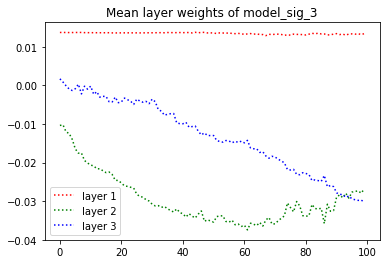

In [9]:
# Visualise the mean weights over epochs:
s3_aveW_L1= [np.mean(W) for W in s3_weights_L1]
s3_aveW_L2= [np.mean(W) for W in s3_weights_L2]
s3_aveW_L3= [np.mean(W) for W in s3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, s3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, s3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, s3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_sig_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_meanW_s3.png')


We can see that the updates of weights in the lower layers are insignificant.

B. Output gradients.

In [10]:
ffn_grad_s3= k.gradients(model_sig_3.output, model_sig_3.trainable_weights)
ffn_grad_s3

[<tf.Tensor 'gradients/dense/MatMul_grad/MatMul_1:0' shape=(2, 3) dtype=float32>,
 <tf.Tensor 'gradients/dense/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients/dense_1/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients/dense_2/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients/dense_2/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients/dense_3/MatMul_grad/MatMul_1:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'gradients/dense_3/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [11]:
sess = k.get_session()

In [12]:
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_s3_L1 = sess.run(ffn_grad_s3[0], feed_dict={model_sig_3.input: xtr})
gradients_s3_L2 = sess.run(ffn_grad_s3[2], feed_dict={model_sig_3.input: xtr})
gradients_s3_L3 = sess.run(ffn_grad_s3[4], feed_dict={model_sig_3.input: xtr})
print('Output grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L1.flatten())).describe())
print('Output grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L2.flatten())).describe())
print('Output grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_s3_L3.flatten())).describe())
gradients_s3_L1

Output grad wrt 1st hidden layer weights 
                   0
count  6.000000e+00
mean   3.063214e-06
std    8.492143e-07
min    1.986914e-06
25%    2.430777e-06
50%    3.100103e-06
75%    3.596528e-06
max    4.222494e-06
Output grad wrt 2nd hidden layer weights 
               0
count  9.000000
mean   0.003369
std    0.001407
min    0.001555
25%    0.001557
50%    0.003861
75%    0.004688
max    0.004695
Output grad wrt 3rd hidden layer weights 
               0
count  9.000000
mean   0.288981
std    0.154049
min    0.116830
25%    0.122343
50%    0.274230
75%    0.462100
max    0.483903


array([[2.8909990e-06, 3.6923016e-06, 1.9869140e-06],
       [3.3092060e-06, 4.2224938e-06, 2.2773693e-06]], dtype=float32)

This is clear sign of vanishing gradients wrt lower layers.

D. Hidden outputs

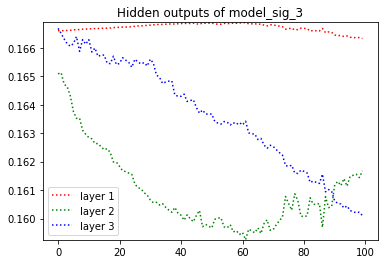

In [13]:
s3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [3,3,3]; input_size= xtr.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= s3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        s3_act_layers[layer, ep]= layer_ave_out
        
acts_L1= s3_act_layers[0]; acts_L2= s3_act_layers[1]; acts_L3= s3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(s3_act_layers), np.max(s3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_sig_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_AE_s3.png')


Layer 1 is saturated from the start.

#### 4.1.3 Use ReLU-class act.fct

In [14]:
# ReLU
model_relu_3= Sequential()  
# Use ReLU hidden layer
model_relu_3.add(Dense(3, input_dim= 2, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(3, input_dim= 3, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(3, input_dim= 3, activation= 'relu', kernel_initializer= 'uniform'))
model_relu_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_relu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_r3 = {}
weight_callback_r3 = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_r3.update({epoch:model_relu_3.get_weights()}))

# Call back the hidden outputs on each epoch
r3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([xtr]) for f in kfunc]
    r3_activations.append(layer_activations)
activations_callback_r3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_relu_3))


# Train model
tr_results = model_relu_3.fit(xtr, ytr, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_r3, activations_callback_r3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 560 samples, validate on 140 samples
Epoch 1/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5214
Epoch 2/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5214


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 3/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 4/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 5/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 6/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 7/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 8/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 9/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 10/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 11/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6928 - val_accuracy: 0.5214
Epoch 12/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6927 - val_accu

Epoch 84/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 85/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 86/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 87/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 88/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 89/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 90/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 91/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 92/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 93/100
560/560 - 0s - loss: 0.6930 - accuracy: 0.5089 - val_loss: 0.6926 - v

A. Change in mean weights 

In [15]:
r3_weights_L1= []
for epoch,weights in weights_dict_r3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    r3_weights_L1.append(weights[0])
    print(weights[0])

Weights for 1st Layer of epoch # 1
[[-0.04289906 -0.04277179  0.03574827]
 [-0.04044154 -0.02226082  0.02060112]]
Weights for 1st Layer of epoch # 2
[[-0.04274109 -0.04283928  0.03574827]
 [-0.04048301 -0.02207275  0.02060112]]
Weights for 1st Layer of epoch # 3
[[-0.04271208 -0.04285167  0.03574827]
 [-0.04049062 -0.02203818  0.02060112]]
Weights for 1st Layer of epoch # 4
[[-0.04270696 -0.04285385  0.03574827]
 [-0.04049196 -0.02203207  0.02060112]]
Weights for 1st Layer of epoch # 5
[[-0.04270609 -0.04285422  0.03574827]
 [-0.04049218 -0.02203103  0.02060112]]
Weights for 1st Layer of epoch # 6
[[-0.04270595 -0.04285429  0.03574827]
 [-0.04049222 -0.02203086  0.02060112]]
Weights for 1st Layer of epoch # 7
[[-0.04270593 -0.04285429  0.03574827]
 [-0.04049222 -0.02203083  0.02060112]]
Weights for 1st Layer of epoch # 8
[[-0.04270593 -0.04285429  0.03574827]
 [-0.04049222 -0.02203083  0.02060112]]
Weights for 1st Layer of epoch # 9
[[-0.04270593 -0.04285429  0.03574827]
 [-0.04049222 

In [16]:
r3_weights_L2= []
for epoch,weights in weights_dict_r3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    r3_weights_L2.append(weights[2])
    print(weights[2])

Weights for 2nd Layer of epoch # 1
[[ 0.03191767  0.03748595  0.02533689]
 [-0.04207414 -0.0194587   0.04293902]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 2
[[ 0.03205771  0.03729736  0.02524986]
 [-0.04200492 -0.01961637  0.04286858]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 3
[[ 0.03208343  0.0372627   0.02523389]
 [-0.04199222 -0.01964534  0.04285566]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 4
[[ 0.03208798  0.03725657  0.02523107]
 [-0.04198997 -0.01965046  0.04285338]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 5
[[ 0.03208875  0.03725553  0.02523059]
 [-0.04198959 -0.01965133  0.04285299]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 6
[[ 0.03208888  0.03725535  0.02523051]
 [-0.04198952 -0.01965148  0.04285292]
 [ 0.02324638 -0.02506081 -0.01012825]]
Weights for 2nd Layer of epoch # 7
[[ 0.03208889  0.03725533  0.0252305 ]
 [-0.041

In [17]:
r3_weights_L3= []
for epoch,weights in weights_dict_r3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    r3_weights_L3.append(weights[4])
    print(weights[4])

Weights for 3rd Layer of epoch # 1
[[-0.0436381  -0.03766463 -0.0254205 ]
 [ 0.00351062  0.03673364  0.01079357]
 [-0.02891982 -0.02739515  0.00168148]]
Weights for 3rd Layer of epoch # 2
[[-0.0436381  -0.03766463 -0.02549717]
 [ 0.00351062  0.03673364  0.01050645]
 [-0.02891982 -0.02739515  0.00124183]]
Weights for 3rd Layer of epoch # 3
[[-0.0436381  -0.03766463 -0.02551124]
 [ 0.00351062  0.03673364  0.01045362]
 [-0.02891982 -0.02739515  0.00116077]]
Weights for 3rd Layer of epoch # 4
[[-0.0436381  -0.03766463 -0.02551372]
 [ 0.00351062  0.03673364  0.01044427]
 [-0.02891982 -0.02739515  0.00114639]]
Weights for 3rd Layer of epoch # 5
[[-0.0436381  -0.03766463 -0.02551415]
 [ 0.00351062  0.03673364  0.01044267]
 [-0.02891982 -0.02739515  0.00114393]]
Weights for 3rd Layer of epoch # 6
[[-0.0436381  -0.03766463 -0.02551422]
 [ 0.00351062  0.03673364  0.01044241]
 [-0.02891982 -0.02739515  0.00114352]]
Weights for 3rd Layer of epoch # 7
[[-0.0436381  -0.03766463 -0.02551422]
 [ 0.003

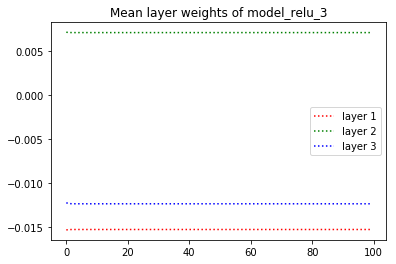

In [18]:
# Visualise the mean weights over epochs:
r3_aveW_L1= [np.mean(W) for W in r3_weights_L1]
r3_aveW_L2= [np.mean(W) for W in r3_weights_L2]
r3_aveW_L3= [np.mean(W) for W in r3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, r3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, r3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, r3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_relu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_meanW_r3.png')


ReLU itself is not effective in fixing the VGP. It has run into the dying-ReLU problem where layer 1 weights remain close to 0. 
<br>
In this case we should check the hidden layer outputs.

C. Output gradients

In [19]:
ffn_grad_r3= k.gradients(model_relu_3.output, model_relu_3.trainable_weights)
ffn_grad_r3

[<tf.Tensor 'gradients_1/dense_4/MatMul_grad/MatMul_1:0' shape=(2, 3) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_4/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_5/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_5/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_6/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_6/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_7/MatMul_grad/MatMul_1:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'gradients_1/dense_7/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [20]:
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_r3_L1 = sess.run(ffn_grad_r3[0], feed_dict={model_relu_3.input: xtr})
gradients_r3_L2 = sess.run(ffn_grad_r3[2], feed_dict={model_relu_3.input: xtr})
gradients_r3_L3 = sess.run(ffn_grad_r3[4], feed_dict={model_relu_3.input: xtr})
print('Output grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_r3_L1.flatten())).describe())
print('Output grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_r3_L2.flatten())).describe())
print('Output grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_r3_L3.flatten())).describe())


Output grad wrt 1st hidden layer weights 
          0
count  6.0
mean   0.0
std    0.0
min    0.0
25%    0.0
50%    0.0
75%    0.0
max    0.0
Output grad wrt 2nd hidden layer weights 
          0
count  9.0
mean   0.0
std    0.0
min    0.0
25%    0.0
50%    0.0
75%    0.0
max    0.0
Output grad wrt 3rd hidden layer weights 
          0
count  9.0
mean   0.0
std    0.0
min    0.0
25%    0.0
50%    0.0
75%    0.0
max    0.0


Potential dying-ReLU problem causes the 3rd layer output gradients to be zeros. 

D. Hidden outputs

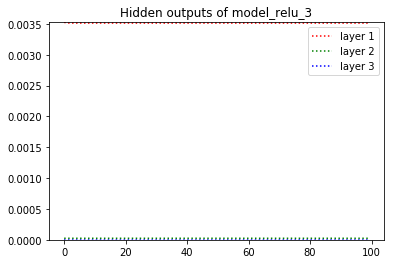

In [21]:
r3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [3,3,3]; input_size= xtr.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= r3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        r3_act_layers[layer, ep]= layer_ave_out
        
acts_L1= r3_act_layers[0]; acts_L2= r3_act_layers[1]; acts_L3= r3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(r3_act_layers), np.max(r3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_relu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_AE_r3.png')


Dying ReLU

### ELU act.fct

In [22]:
# ELU
model_elu_3= Sequential()  
# Use ELU hidden layer
model_elu_3.add(Dense(3, input_dim= 2, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', kernel_initializer= 'uniform'))
model_elu_3.add(Dense(1, activation= 'sigmoid', kernel_initializer= 'uniform'))
model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Call back the weights on each epoch
weights_dict_e3 = {}
weight_callback_e3 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

# Call back the hidden outputs on each epoch
e3_activations= []  # [epoch][layer][0][X][unit]
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([xtr]) for f in kfunc]
    e3_activations.append(layer_activations)
activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))


# Train model
tr_results = model_elu_3.fit(xtr, ytr, validation_split=0.2, epochs=100, batch_size=32, 
                             verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])
print('Max val acc:', np.amax(tr_results.history['val_accuracy']))


Train on 560 samples, validate on 140 samples
Epoch 1/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.4607 - val_loss: 0.6932 - val_accuracy: 0.4786


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 2/100
560/560 - 0s - loss: 0.6932 - accuracy: 0.4839 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 3/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 4/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 5/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 6/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 7/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 8/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5214
Epoch 9/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 10/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accuracy: 0.5214
Epoch 11/100
560/560 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6929 - val_accur

Epoch 83/100
560/560 - 0s - loss: 0.6301 - accuracy: 0.6214 - val_loss: 0.6503 - val_accuracy: 0.5643
Epoch 84/100
560/560 - 0s - loss: 0.6240 - accuracy: 0.6214 - val_loss: 0.6435 - val_accuracy: 0.5786
Epoch 85/100
560/560 - 0s - loss: 0.6179 - accuracy: 0.6214 - val_loss: 0.6376 - val_accuracy: 0.5929
Epoch 86/100
560/560 - 0s - loss: 0.6117 - accuracy: 0.6286 - val_loss: 0.6312 - val_accuracy: 0.6000
Epoch 87/100
560/560 - 0s - loss: 0.6063 - accuracy: 0.6321 - val_loss: 0.6254 - val_accuracy: 0.6000
Epoch 88/100
560/560 - 0s - loss: 0.6009 - accuracy: 0.6357 - val_loss: 0.6205 - val_accuracy: 0.6000
Epoch 89/100
560/560 - 0s - loss: 0.5955 - accuracy: 0.6357 - val_loss: 0.6157 - val_accuracy: 0.6000
Epoch 90/100
560/560 - 0s - loss: 0.5902 - accuracy: 0.6357 - val_loss: 0.6100 - val_accuracy: 0.6143
Epoch 91/100
560/560 - 0s - loss: 0.5856 - accuracy: 0.6429 - val_loss: 0.6049 - val_accuracy: 0.6071
Epoch 92/100
560/560 - 0s - loss: 0.5804 - accuracy: 0.6464 - val_loss: 0.6007 - v

After the 25th epoch there has been further improvement in accuracy.

A. Change in mean weights

In [23]:
e3_weights_L1= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    e3_weights_L1.append(weights[0])
    print(weights[0])

Weights for 1st Layer of epoch # 1
[[-0.00530837  0.01826352  0.01734162]
 [-0.01360945 -0.00246948 -0.01164713]]
Weights for 1st Layer of epoch # 2
[[-0.0051877   0.01770693  0.01838007]
 [-0.01344168 -0.00175073 -0.01266378]]
Weights for 1st Layer of epoch # 3
[[-5.1511801e-03  1.7661393e-02  1.8292036e-02]
 [-1.2454770e-02  8.0749596e-05 -1.4235200e-02]]
Weights for 1st Layer of epoch # 4
[[-0.00556486  0.01701723  0.01882319]
 [-0.01116409  0.0023456  -0.01608295]]
Weights for 1st Layer of epoch # 5
[[-0.00631439  0.01568002  0.02021309]
 [-0.01073801  0.00313979 -0.01682803]]
Weights for 1st Layer of epoch # 6
[[-0.00646298  0.01537932  0.02046428]
 [-0.01070279  0.00310288 -0.01664839]]
Weights for 1st Layer of epoch # 7
[[-0.00650357  0.01432106  0.02220518]
 [-0.0107279   0.00371816 -0.01776259]]
Weights for 1st Layer of epoch # 8
[[-0.00639634  0.01384053  0.02289869]
 [-0.01104803  0.00439787 -0.0195733 ]]
Weights for 1st Layer of epoch # 9
[[-0.00567712  0.01350392  0.024367

In [24]:
e3_weights_L2= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    e3_weights_L2.append(weights[2])
    print(weights[2])

Weights for 2nd Layer of epoch # 1
[[ 0.010727   -0.0210712   0.00965991]
 [-0.01680459 -0.01836186  0.04599854]
 [ 0.03782773 -0.00155028 -0.03082878]]
Weights for 2nd Layer of epoch # 2
[[ 0.01093082 -0.02066686  0.00970905]
 [-0.01599027 -0.01784428  0.04622079]
 [ 0.03888093 -0.00105827 -0.03053666]]
Weights for 2nd Layer of epoch # 3
[[ 0.0118448  -0.01938594  0.00979051]
 [-0.01573496 -0.01752788  0.0461136 ]
 [ 0.03933475 -0.0005033  -0.03065448]]
Weights for 2nd Layer of epoch # 4
[[ 0.01266909 -0.01815468  0.00961158]
 [-0.01511825 -0.01664905  0.04607149]
 [ 0.04025989  0.0008508  -0.03084786]]
Weights for 2nd Layer of epoch # 5
[[ 0.01277561 -0.01801122  0.00960308]
 [-0.01410092 -0.01528543  0.04614267]
 [ 0.0412628   0.00216589 -0.03075373]]
Weights for 2nd Layer of epoch # 6
[[ 0.01273024 -0.01801093  0.00967533]
 [-0.01385096 -0.0149978   0.04609481]
 [ 0.04133488  0.0023065  -0.03071286]]
Weights for 2nd Layer of epoch # 7
[[ 0.01282789 -0.0179586   0.00972493]
 [-0.013

In [25]:
e3_weights_L3= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    e3_weights_L3.append(weights[4])
    print(weights[4])

Weights for 3rd Layer of epoch # 1
[[ 0.02395231  0.03252111 -0.04150521]
 [-0.00778934 -0.00274936 -0.04234906]
 [-0.0140174  -0.01341574 -0.03573881]]
Weights for 3rd Layer of epoch # 2
[[ 0.02032953  0.03599137 -0.03952344]
 [-0.00254775 -0.00778442 -0.0444962 ]
 [-0.01966653 -0.00813146 -0.03219713]]
Weights for 3rd Layer of epoch # 3
[[ 0.01936136  0.03701191 -0.03857893]
 [-0.00319312 -0.00725794 -0.04274204]
 [-0.02036016 -0.00740683 -0.03197121]]
Weights for 3rd Layer of epoch # 4
[[ 0.01859845  0.03784524 -0.03764685]
 [-0.00560982 -0.00511714 -0.03964681]
 [-0.01928781 -0.00834083 -0.03347746]]
Weights for 3rd Layer of epoch # 5
[[ 0.01697608  0.0394948  -0.03585542]
 [-0.00895154 -0.00223819 -0.03581172]
 [-0.01943003 -0.00831449 -0.0336397 ]]
Weights for 3rd Layer of epoch # 6
[[ 0.01689184  0.03961524 -0.03568964]
 [-0.0102776  -0.0011142  -0.03435802]
 [-0.01970031 -0.00811264 -0.03345862]]
Weights for 3rd Layer of epoch # 7
[[ 0.01797223  0.0386259  -0.03669932]
 [-0.011

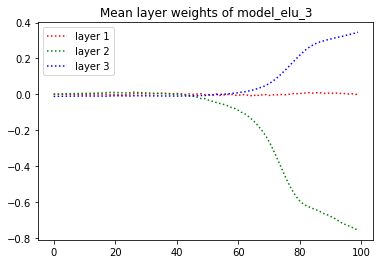

In [26]:
# Visualise the mean weights over epochs:
e3_aveW_L1= [np.mean(W) for W in e3_weights_L1]
e3_aveW_L2= [np.mean(W) for W in e3_weights_L2]
e3_aveW_L3= [np.mean(W) for W in e3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, e3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, e3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, e3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_meanW_e3.png')


No frozen model parameters.

B. Output gradients

In [27]:
ffn_grad_e3= k.gradients(model_elu_3.output, model_elu_3.trainable_weights)
ffn_grad_e3

[<tf.Tensor 'gradients_2/dense_8/MatMul_grad/MatMul_1:0' shape=(2, 3) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_8/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_9/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_9/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_10/MatMul_grad/MatMul_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_10/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_11/MatMul_grad/MatMul_1:0' shape=(3, 1) dtype=float32>,
 <tf.Tensor 'gradients_2/dense_11/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]

In [28]:
# Print out the (absolute) summary statistics of loss gradients wrt weights on each layer:
gradients_e3_L1 = sess.run(ffn_grad_e3[0], feed_dict={model_elu_3.input: xtr})
gradients_e3_L2 = sess.run(ffn_grad_e3[2], feed_dict={model_elu_3.input: xtr})
gradients_e3_L3 = sess.run(ffn_grad_e3[4], feed_dict={model_elu_3.input: xtr})
print('Output grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L1.flatten())).describe())
print('Output grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L2.flatten())).describe())
print('Output grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L3.flatten())).describe())


Output grad wrt 1st hidden layer weights 
                0
count   6.000000
mean   29.554108
std     0.417536
min    29.061775
25%    29.230910
50%    29.545041
75%    29.918983
max    30.002937
Output grad wrt 2nd hidden layer weights 
                0
count   9.000000
mean   10.306089
std    15.158647
min     0.080480
25%     0.229858
50%     0.272872
75%    30.209204
max    30.678955
Output grad wrt 3rd hidden layer weights 
                0
count   9.000000
mean   27.224905
std    32.406174
min     3.177753
25%     5.723005
50%     6.618565
75%    59.163147
max    87.112213


No vanishing gradients on any layers. The std are also smaller. 

D. Hidden outputs

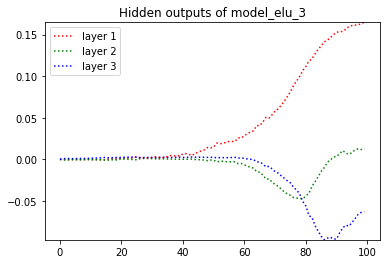

In [29]:
e3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [3,3,3]; input_size= xtr.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= e3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        e3_act_layers[layer, ep]= layer_ave_out
        
acts_L1= e3_act_layers[0]; acts_L2= e3_act_layers[1]; acts_L3= e3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(e3_act_layers), np.max(e3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_AE_e3.png')


No saturation of activation functions. 

#### 4.1.4 Weight initialisation on ELU model
While the normalised intialisation from Glorot & Bengio (2010) is a popular choice, there have been various different initialisation schemes introduced since. Here we run a hyperparameter tuning on the ELU model. 

In [30]:
def data():
    X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    # split into train and test
    xtr, xte, ytr, yte= train_test_split(X, y,random_state= 42,test_size= 0.3, shuffle= True)
    return xtr, xte, ytr, yte

def create_model_e3(xtr, ytr):
    model_elu_3= Sequential()  
    # Use ELU hidden layer
    model_elu_3.add(Dense(3, input_dim= 2, activation= 'elu', 
                          kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.add(Dense(1, activation= 'sigmoid', 
                         kernel_initializer= {{choice(['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal','glorot_uniform', 'he_normal', 'he_uniform'])}}))
    model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

    # Callback the weights on each epoch
    weights_dict_e3 = {}
    weight_callback_e3 = LambdaCallback \
    ( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

    # Callback the hidden activations on each epoch
    e3_activations= []
    def save_act(model):
        outputs= [layer.output for layer in model.layers]
        kfunc= [k.function([model.input], [out]) for out in outputs]
        layer_activations= [ f([xtr]) for f in kfunc]
        e3_activations.append(layer_activations)
    activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))

    # Train model
    tr_results = model_elu_3.fit(xtr, ytr, validation_split=0.2, epochs=100, batch_size=32, 
                                 verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])
    val_acc= np.amax(tr_results.history['val_accuracy'])
    return{'loss':-val_acc, 'status': STATUS_OK, 'model': model_elu_3, 
          'perepoch_weights': weights_dict_e3, 'hidden_acts':e3_activations}
    
    
if __name__ == '__main__':
    xtr, xte, ytr, yte= data()
    best_run, best_model= optim.minimize(model= create_model_e3, data= data,
                                        algo= tpe.suggest, max_evals= 1, trials= Trials(),
                                        eval_space= True, notebook_name= 'VGP_1_FFN')
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from numpy import array, asarray, zeros
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.datasets import make_circles
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import Input, Model
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.recurrent import LSTM, GRU, SimpleRNN
except:
    pass

try:
    from keras.layers.core import Dense, Activation, Dropout, Flatten
except:
    pass

try:
    from keras.layers.embeddings import Embedding
except:
    pass

try:

/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.




560/560 - 0s - loss: 0.6907 - accuracy: 0.6321 - val_loss: 0.6880 - val_accuracy: 0.6857

Epoch 3/100                                          
560/560 - 0s - loss: 0.6889 - accuracy: 0.6286 - val_loss: 0.6857 - val_accuracy: 0.6857

Epoch 4/100                                          
560/560 - 0s - loss: 0.6870 - accuracy: 0.6107 - val_loss: 0.6826 - val_accuracy: 0.6786

Epoch 5/100                                          
560/560 - 0s - loss: 0.6844 - accuracy: 0.5821 - val_loss: 0.6791 - val_accuracy: 0.6714

Epoch 6/100                                          
560/560 - 0s - loss: 0.6817 - accuracy: 0.6161 - val_loss: 0.6756 - val_accuracy: 0.7286

Epoch 7/100                                          
560/560 - 0s - loss: 0.6778 - accuracy: 0.6554 - val_loss: 0.6692 - val_accuracy: 0.7000

Epoch 8/100                                          
560/560 - 0s - loss: 0.6735 - accuracy: 0.6821 - val_loss: 0.6641 - val_accuracy: 0.7786

Epoch 9/100                                   

Fit the ELU model with the optimal intialisation schemes each layer.

In [31]:
xtr, xte, ytr, yte= data()
model_elu_3= Sequential()  
# Use ELU hidden layer
model_elu_3.add(Dense(3, input_dim= 2, activation= 'elu', kernel_initializer= 'he_normal'))
model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', kernel_initializer='uniform'))
model_elu_3.add(Dense(3, input_dim= 3, activation= 'elu', kernel_initializer= 'lecun_uniform'))
model_elu_3.add(Dense(1, activation= 'sigmoid',  kernel_initializer= 'he_normal'))
model_elu_3.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# Callback the weights on each epoch
weights_dict_e3 = {}
weight_callback_e3 = LambdaCallback \
( on_epoch_end=lambda epoch, logs:  weights_dict_e3.update({epoch:model_elu_3.get_weights()}))

# Callback the hidden activations on each epoch
e3_activations= []
def save_act(model):
    outputs= [layer.output for layer in model.layers]
    kfunc= [k.function([model.input], [out]) for out in outputs]
    layer_activations= [ f([xtr]) for f in kfunc]
    e3_activations.append(layer_activations)
activations_callback_e3= LambdaCallback(on_epoch_end= lambda epoch, logs:save_act(model_elu_3))

# Train model
tr_results = model_elu_3.fit(xtr, ytr, validation_split=0.2, epochs=100, batch_size=32, 
                            verbose=2, callbacks=[weight_callback_e3, activations_callback_e3])

e3_act_layers= np.zeros((3, 100))  # each row is mean activation for that hidden layer
layer_sizes= [3,3,3]; input_size= xtr.shape[0]
for ep in range(100):
    for layer in range(3):
        layer_outs= np.zeros((layer_sizes[layer], input_size))  
        # This is the activations for each layer over all inputs
        for inp in range(input_size):
            hidden_outputs= e3_activations[ep][layer][0][inp]
            layer_outs[layer, inp]= np.mean(hidden_outputs)
        layer_ave_out= np.mean(layer_outs)
        e3_act_layers[layer, ep]= layer_ave_out

Train on 560 samples, validate on 140 samples
Epoch 1/100


/Users/necromancerchenmy/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



560/560 - 0s - loss: 0.6931 - accuracy: 0.4607 - val_loss: 0.6935 - val_accuracy: 0.4357
Epoch 2/100
560/560 - 0s - loss: 0.6924 - accuracy: 0.5196 - val_loss: 0.6941 - val_accuracy: 0.4357
Epoch 3/100
560/560 - 0s - loss: 0.6919 - accuracy: 0.5196 - val_loss: 0.6949 - val_accuracy: 0.4357
Epoch 4/100
560/560 - 0s - loss: 0.6914 - accuracy: 0.5196 - val_loss: 0.6948 - val_accuracy: 0.4357
Epoch 5/100
560/560 - 0s - loss: 0.6909 - accuracy: 0.5054 - val_loss: 0.6944 - val_accuracy: 0.4000
Epoch 6/100
560/560 - 0s - loss: 0.6905 - accuracy: 0.4696 - val_loss: 0.6949 - val_accuracy: 0.4071
Epoch 7/100
560/560 - 0s - loss: 0.6901 - accuracy: 0.4393 - val_loss: 0.6938 - val_accuracy: 0.3214
Epoch 8/100
560/560 - 0s - loss: 0.6893 - accuracy: 0.4393 - val_loss: 0.6945 - val_accuracy: 0.3643
Epoch 9/100
560/560 - 0s - loss: 0.6886 - accuracy: 0.4464 - val_loss: 0.6938 - val_accuracy: 0.3500
Epoch 10/100
560/560 - 0s - loss: 0.6877 - accuracy: 0.4714 - val_loss: 0.6929 - val_accuracy: 0.4000
E

Epoch 82/100
560/560 - 0s - loss: 0.1059 - accuracy: 0.9893 - val_loss: 0.0883 - val_accuracy: 0.9929
Epoch 83/100
560/560 - 0s - loss: 0.0993 - accuracy: 0.9911 - val_loss: 0.0831 - val_accuracy: 0.9929
Epoch 84/100
560/560 - 0s - loss: 0.0932 - accuracy: 0.9911 - val_loss: 0.0789 - val_accuracy: 0.9929
Epoch 85/100
560/560 - 0s - loss: 0.0878 - accuracy: 0.9911 - val_loss: 0.0748 - val_accuracy: 0.9929
Epoch 86/100
560/560 - 0s - loss: 0.0824 - accuracy: 0.9929 - val_loss: 0.0711 - val_accuracy: 0.9929
Epoch 87/100
560/560 - 0s - loss: 0.0784 - accuracy: 0.9911 - val_loss: 0.0679 - val_accuracy: 0.9929
Epoch 88/100
560/560 - 0s - loss: 0.0745 - accuracy: 0.9946 - val_loss: 0.0651 - val_accuracy: 0.9929
Epoch 89/100
560/560 - 0s - loss: 0.0703 - accuracy: 0.9929 - val_loss: 0.0620 - val_accuracy: 0.9929
Epoch 90/100
560/560 - 0s - loss: 0.0667 - accuracy: 0.9929 - val_loss: 0.0600 - val_accuracy: 0.9929
Epoch 91/100
560/560 - 0s - loss: 0.0641 - accuracy: 0.9929 - val_loss: 0.0577 - v

Considerable higher accuracy.
<br>
Again check for the signs of VGP.


Weights for 1st Layer of epoch # 1
[[-1.6329503  -0.6601066  -0.0622843 ]
 [-0.35354656  0.71216    -2.2563944 ]]
Weights for 1st Layer of epoch # 2
[[-1.6244143  -0.66827124 -0.05868025]
 [-0.35462517  0.72504574 -2.2688692 ]]
Weights for 1st Layer of epoch # 3
[[-1.6224551  -0.675274   -0.05844941]
 [-0.3537964   0.7397904  -2.283477  ]]
Weights for 1st Layer of epoch # 4
[[-1.6283089  -0.6800533  -0.05490606]
 [-0.351197    0.75731117 -2.2996058 ]]
Weights for 1st Layer of epoch # 5
[[-1.6362287  -0.68016875 -0.04696522]
 [-0.34832114  0.7749306  -2.3145614 ]]
Weights for 1st Layer of epoch # 6
[[-1.6472756  -0.6814013  -0.04025641]
 [-0.3438747   0.7950206  -2.3307168 ]]
Weights for 1st Layer of epoch # 7
[[-1.6606212  -0.6852191  -0.03358023]
 [-0.34152097  0.8117207  -2.3481455 ]]
Weights for 1st Layer of epoch # 8
[[-1.6712512  -0.68114865 -0.02155047]
 [-0.33301336  0.8348102  -2.3650427 ]]
Weights for 1st Layer of epoch # 9
[[-1.684991   -0.682913   -0.01420646]
 [-0.33058095 

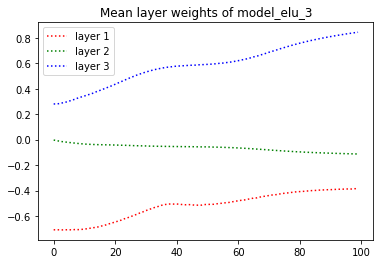

In [32]:
# A. Mean weights per epoch

e3_weights_L1= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 1st Layer of epoch #',epoch+1)
    e3_weights_L1.append(weights[0])
    print(weights[0])
    
e3_weights_L2= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 2nd Layer of epoch #',epoch+1)
    e3_weights_L2.append(weights[2])
    print(weights[2])
    
e3_weights_L3= []
for epoch,weights in weights_dict_e3.items():
    # Each of the 100 'weights' contains 3 objects (weights and biases) 
    print('Weights for 3rd Layer of epoch #',epoch+1)
    e3_weights_L3.append(weights[4])
    print(weights[4])
    
# Visualise the mean weights over epochs:
e3_aveW_L1= [np.mean(W) for W in e3_weights_L1]
e3_aveW_L2= [np.mean(W) for W in e3_weights_L2]
e3_aveW_L3= [np.mean(W) for W in e3_weights_L3]

epochs= [ep for ep in range(100)]
plt.plot(epochs, e3_aveW_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, e3_aveW_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, e3_aveW_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.legend()
plt.title('Mean layer weights of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_meanW_e3_init.png')


Loss grad wrt 1st hidden layer weights 
                0
count   6.000000
mean   26.443552
std    16.419140
min     3.161766
25%    17.925362
50%    25.274036
75%    36.475880
max    49.265862
Loss grad wrt 2nd hidden layer weights 
                0
count   9.000000
mean   35.926678
std    30.095448
min     5.743889
25%     9.483035
50%    27.032574
75%    57.069511
max    87.579208
Loss grad wrt 3rd hidden layer weights 
               0
count  9.000000
mean   1.295284
std    0.637148
min    0.414370
25%    0.848209
50%    1.163098
75%    1.835442
max    2.322047


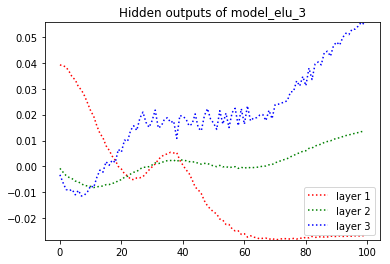

In [33]:
# 2. Loss gradients wrt weights
ffn_grad_e3= k.gradients(model_elu_3.output, model_elu_3.trainable_weights)
gradients_e3_L1 = sess.run(ffn_grad_e3[0], feed_dict={model_elu_3.input: xtr})
gradients_e3_L2 = sess.run(ffn_grad_e3[2], feed_dict={model_elu_3.input: xtr})
gradients_e3_L3 = sess.run(ffn_grad_e3[4], feed_dict={model_elu_3.input: xtr})
print('Loss grad wrt 1st hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L1.flatten())).describe())
print('Loss grad wrt 2nd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L2.flatten())).describe())
print('Loss grad wrt 3rd hidden layer weights \n',abs(pd.DataFrame(gradients_e3_L3.flatten())).describe())
gradients_e3_L1


# 3. Hidden activations per epoch
acts_L1= e3_act_layers[0]; acts_L2= e3_act_layers[1]; acts_L3= e3_act_layers[2]
epochs= [ep for ep in range(100)]
plt.plot(epochs, acts_L1, linestyle = 'dotted', color= 'red', label= 'layer 1')
plt.plot(epochs, acts_L2, linestyle = 'dotted', color= 'green', label= 'layer 2')
plt.plot(epochs, acts_L3, linestyle = 'dotted', color= 'blue', label= 'layer 3')
plt.ylim((np.min(e3_act_layers), np.max(e3_act_layers)))
plt.legend()
plt.title('Hidden outputs of model_elu_3')
plt.savefig('/Users/necromancerchenmy/Desktop/honours thesis/thesis/thesis proposal/thesis proposal/circle_AE_e3_init.png')
